In [47]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,
                              StackingClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import warnings

In [48]:
df = pd.read_csv("df.csv")
df_bin = pd.read_csv("df_bin.csv")
df_cut = pd.read_csv("df_cut.csv")
df_cut_bin = pd.read_csv("df_cut_bin.csv")

Сравниваем разные модели

In [50]:
#df = df.drop(columns=['CC50, mM'])
df = df.drop(columns=['log_CC50'])
df = df.drop(columns=['SI'])
df_bin = df_bin.drop(columns=['log_CC50'])
#df_bin = df_bin.drop(columns=['CC50, mM'])
df_bin = df_bin.drop(columns=['SI'])
df_cut = df_cut.drop(columns=['log_CC50'])
#df_cut = df_cut.drop(columns=['CC50, mM'])
df_cut = df_cut.drop(columns=['SI'])
#df_cut_bin = df_cut_bin.drop(columns=['log_CC50'])
#df_cut_bin = df_cut_bin.drop(columns=['CC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['SI'])
df = df.drop(columns=['log_SI'])
df_bin = df_bin.drop(columns=['log_SI'])
df_cut = df_cut.drop(columns=['log_SI'])
df_cut_bin = df_cut_bin.drop(columns=['log_SI'])
df = df.drop(columns=['IC50, mM'])
df_bin = df_bin.drop(columns=['IC50, mM'])
df_cut = df_cut.drop(columns=['IC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['IC50, mM'])
df = df.drop(columns=['log_IC50'])
#df_bin = df_bin.drop(columns=['log_IC50'])
df_cut = df_cut.drop(columns=['log_IC50'])
df_cut_bin = df_cut_bin.drop(columns=['log_IC50'])

Starting 10-fold CV with internal log_IC50 regression...
Fold 1: Accuracy=0.7822, ROC AUC=0.8972
Fold 2: Accuracy=0.7900, ROC AUC=0.8873
Fold 3: Accuracy=0.6700, ROC AUC=0.8172
Fold 4: Accuracy=0.7600, ROC AUC=0.8576
Fold 5: Accuracy=0.6600, ROC AUC=0.7784
Fold 6: Accuracy=0.7200, ROC AUC=0.8017
Fold 7: Accuracy=0.8000, ROC AUC=0.8690
Fold 8: Accuracy=0.7600, ROC AUC=0.8411
Fold 9: Accuracy=0.7200, ROC AUC=0.8519
Fold 10: Accuracy=0.8200, ROC AUC=0.8887

CV Mean Accuracy: 0.7482 ± 0.0515
CV Mean ROC AUC:  0.8490 ± 0.0376

Training final regression model for log_IC50 on full data...

Test set classification report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       101
           1       0.73      0.88      0.80       100

    accuracy                           0.78       201
   macro avg       0.79      0.78      0.77       201
weighted avg       0.79      0.78      0.77       201

Test Accuracy: 0.7761
Test ROC AUC:  0.9095


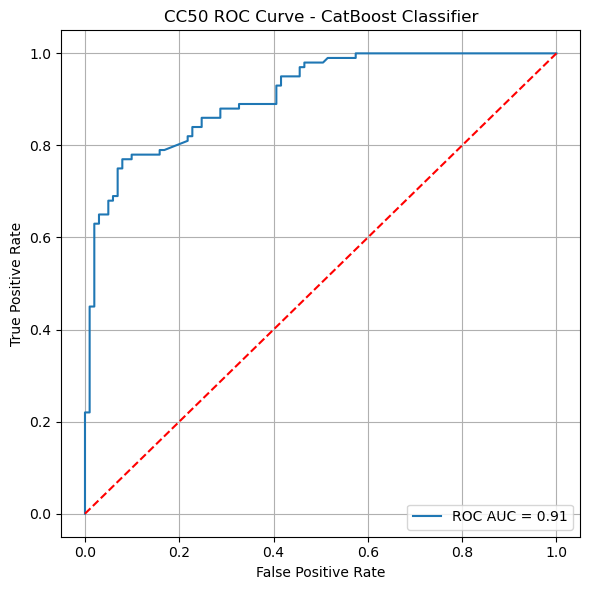

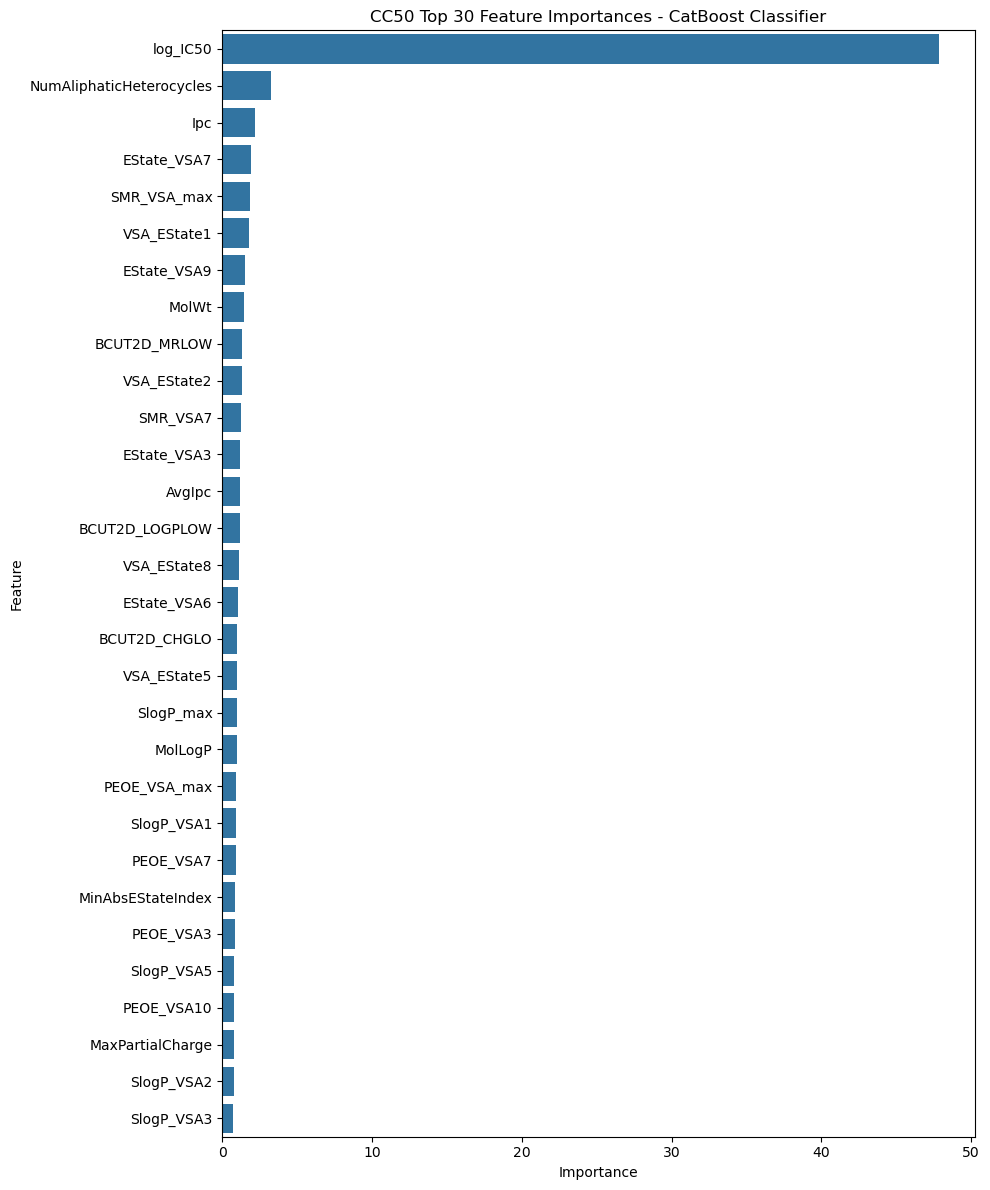


Модель сохранена как 'CC50_classifier_catboost_final_model.pkl'


In [54]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import joblib

# --- 0. Предполагается, что df_cut загружен и содержит данные ---

df = df_cut.copy()

# Приводим имена колонок к удобному формату
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Заменяем inf на NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Если есть лишние колонки, удаляем (например, "CC50_above_median")
df.drop(columns=['CC50_above_median'], errors='ignore', inplace=True)

# --- Выделяем целевую переменную CC50 ---

cc50_cols = [col for col in df.columns if 'cc50' in col.lower()]
if not cc50_cols:
    raise ValueError("Нет колонки с CC50")
cc50_col = cc50_cols[0]

CC50 = df[cc50_col]

# --- Формируем признаки без колонки CC50 ---

X = df.drop(columns=[cc50_col])

# --- 1. Кросс-валидация с внутренним обучением регрессора для log_IC50 ---

kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list = []
roc_auc_list = []

print("Starting 10-fold CV with internal log_IC50 regression...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    # Разделяем данные фолда
    X_train = X.iloc[train_idx].copy()
    X_val = X.iloc[val_idx].copy()
    y_train_cc50 = CC50.iloc[train_idx]
    y_val_cc50 = CC50.iloc[val_idx]

    # --- Обучаем регрессию log_IC50 на обучающей части ---
    regressor = CatBoostRegressor(
        depth=6,
        iterations=100,
        learning_rate=0.05,
        verbose=0,
        random_state=42,
        task_type='GPU'
    )

    # Импутация и масштабирование для регрессора (обучение только на train)
    imp_reg = SimpleImputer(strategy='most_frequent')
    X_train_imp_reg = pd.DataFrame(imp_reg.fit_transform(X_train), columns=X_train.columns)
    X_val_imp_reg = pd.DataFrame(imp_reg.transform(X_val), columns=X_val.columns)

    scaler_reg = RobustScaler()
    X_train_scaled_reg = pd.DataFrame(scaler_reg.fit_transform(X_train_imp_reg), columns=X_train.columns)
    X_val_scaled_reg = pd.DataFrame(scaler_reg.transform(X_val_imp_reg), columns=X_val.columns)

    regressor.fit(X_train_scaled_reg, y_train_cc50)

    # Предсказания log_IC50
    X_train['log_IC50'] = regressor.predict(X_train_scaled_reg)
    X_val['log_IC50'] = regressor.predict(X_val_scaled_reg)

    # --- Бинаризация цели ---
    median_train = y_train_cc50.median()
    y_train_bin = (y_train_cc50 > median_train).astype(int)
    y_val_bin = (y_val_cc50 > median_train).astype(int)

    # --- Импутация и масштабирование признаков для классификации ---
    imp_cls = SimpleImputer(strategy='most_frequent')
    X_train_imp_cls = pd.DataFrame(imp_cls.fit_transform(X_train), columns=X_train.columns)
    X_val_imp_cls = pd.DataFrame(imp_cls.transform(X_val), columns=X_val.columns)

    scaler_cls = RobustScaler()
    X_train_scaled_cls = pd.DataFrame(scaler_cls.fit_transform(X_train_imp_cls), columns=X_train.columns)
    X_val_scaled_cls = pd.DataFrame(scaler_cls.transform(X_val_imp_cls), columns=X_val.columns)

    # --- Обучение классификатора ---
    clf = CatBoostClassifier(
        depth=6,
        iterations=100,
        l2_leaf_reg=5,
        learning_rate=0.05,
        verbose=0,
        random_state=42,
        task_type='GPU'
    )
    clf.fit(X_train_scaled_cls, y_train_bin)

    y_pred = clf.predict(X_val_scaled_cls)
    y_proba = clf.predict_proba(X_val_scaled_cls)[:, 1]

    acc = accuracy_score(y_val_bin, y_pred)
    roc_auc = roc_auc_score(y_val_bin, y_proba)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold}: Accuracy={acc:.4f}, ROC AUC={roc_auc:.4f}")

print(f"\nCV Mean Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"CV Mean ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 2. Обучение регрессора log_IC50 на всём датасете для финального признака ---

print("\nTraining final regression model for log_IC50 on full data...")

imp_reg_full = SimpleImputer(strategy='most_frequent')
X_imp_full = pd.DataFrame(imp_reg_full.fit_transform(X), columns=X.columns)

scaler_reg_full = RobustScaler()
X_scaled_full = pd.DataFrame(scaler_reg_full.fit_transform(X_imp_full), columns=X.columns)

regressor_full = CatBoostRegressor(
    depth=6,
    iterations=100,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    task_type='GPU'
)
regressor_full.fit(X_scaled_full, CC50)

df['log_IC50'] = regressor_full.predict(X_scaled_full)

# Добавляем log_IC50 в признаки для классификации
X_full = X.copy()
X_full['log_IC50'] = df['log_IC50']

# Импутация и масштабирование для классификации
imp_cls_full = SimpleImputer(strategy='most_frequent')
X_imp_cls_full = pd.DataFrame(imp_cls_full.fit_transform(X_full), columns=X_full.columns)

scaler_cls_full = RobustScaler()
X_scaled_cls_full = pd.DataFrame(scaler_cls_full.fit_transform(X_imp_cls_full), columns=X_full.columns)

# --- 3. Финальное обучение классификатора на полном наборе ---

y_full_bin = (CC50 > CC50.median()).astype(int)

clf_final = CatBoostClassifier(
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    task_type='GPU'
)
clf_final.fit(X_scaled_cls_full, y_full_bin)

# --- 4. Разделение на train/test и оценка ---

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_cls_full, y_full_bin, test_size=0.2, random_state=42, stratify=y_full_bin
)

clf_eval = CatBoostClassifier(
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    task_type='GPU'
)
clf_eval.fit(X_train, y_train)

y_pred_test = clf_eval.predict(X_test)
y_proba_test = clf_eval.predict_proba(X_test)[:, 1]

print("\nTest set classification report:")
print(classification_report(y_test, y_pred_test))

acc_test = accuracy_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_proba_test)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 5. ROC-кривая ---

fpr, tpr, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CC50 ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_classifier_roc_curve_classification.png")
plt.show()

# --- 6. Важность признаков ---

feature_importances = clf_final.get_feature_importance(Pool(X_scaled_cls_full, label=y_full_bin))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled_cls_full.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("CC50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("CC50_classification_feature_importance.png")
plt.show()

# --- 7. Сохранение модели ---

joblib.dump(clf_final, 'CC50_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'CC50_classifier_catboost_final_model.pkl'")


In [5]:
!pip install gputil

In [79]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from matplotlib.backends.backend_pdf import PdfPages
import GPUtil

# Проверка GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Используется CPU.")

# Подготовка моделей
xgb_gpu = XGBClassifier(tree_method='gpu_hist' if "XGBoost" in gpu_models else 'auto',
                        random_state=42, use_label_encoder=False,
                        eval_metric='logloss', n_jobs=1)

lgbm_gpu = LGBMClassifier(device='gpu' if "LightGBM" in gpu_models else 'cpu',
                          random_state=42, n_jobs=1)

catboost_gpu = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

estimators_cls = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=1)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', xgb_gpu),
    ('cat', catboost_gpu)
]
final_estimator_cls = LogisticRegression()
stacking_model_cls = StackingClassifier(
    estimators=estimators_cls,
    final_estimator=final_estimator_cls,
    cv=5,
    n_jobs=1
)

class_models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_jobs=1),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb_gpu,
    "LightGBM": lgbm_gpu,
    "CatBoost": catboost_gpu,
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Stacking": stacking_model_cls
}

def get_stratified_folds_with_target(df, n_splits=5):
    df = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_results = []

    features = df.drop(columns=["CC50_mM"], errors="ignore").columns.tolist()
    if "CC50_above_median" in features:
        features.remove("CC50_above_median")

    for train_idx, test_idx in kf.split(df):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        median = train_df["CC50_mM"].median()
        train_df["target"] = (train_df["CC50_mM"] > median).astype(int)
        test_df["target"] = (test_df["CC50_mM"] > median).astype(int)

        # Препроцессинг
        X_train = train_df[features]
        X_test = test_df[features]

        y_train = train_df["target"]
        y_test = test_df["target"]

        imp = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

        all_results.append((X_train_scaled, X_test_scaled, y_train, y_test))

    return all_results

def evaluate_models_cv(df, dataset_name="df"):
    results = []
    cv_data = get_stratified_folds_with_target(df)

    for model_name, model in tqdm(class_models.items(), desc=f"Evaluating on {dataset_name}"):
        metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

        for X_train, X_test, y_train, y_test in cv_data:
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]

                metrics['accuracy'].append(accuracy_score(y_test, y_pred))
                metrics['precision'].append(precision_score(y_test, y_pred))
                metrics['recall'].append(recall_score(y_test, y_pred))
                metrics['f1'].append(f1_score(y_test, y_pred))
                metrics['roc_auc'].append(roc_auc_score(y_test, y_proba))
            except Exception as e:
                print(f"[!] Model {model_name} error: {e}")
                continue

        results.append({
            "Model": model_name,
            "Accuracy": np.mean(metrics['accuracy']),
            "Precision": np.mean(metrics['precision']),
            "Recall": np.mean(metrics['recall']),
            "F1": np.mean(metrics['f1']),
            "ROC AUC": np.mean(metrics['roc_auc']),
            "Dataset": dataset_name
        })

    return pd.DataFrame(results)

# Очистка и подготовка исходных датафреймов
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаляем 'CC50_above_median' если уже есть
for d in [df, df_cut, df_bin, df_cut_bin]:
    if "CC50_above_median" in d.columns:
        d.drop(columns=["CC50_above_median"], inplace=True)

# Оценка
results_df = evaluate_models_cv(df.copy(), dataset_name="df")
results_cut = evaluate_models_cv(df_cut.copy(), dataset_name="df_cut")
results_bin = evaluate_models_cv(df_bin.copy(), dataset_name="df_bin")
results_cut_bin = evaluate_models_cv(df_cut_bin.copy(), dataset_name="df_cut_bin")

comparison_cls = pd.concat([results_df, results_cut, results_bin, results_cut_bin], ignore_index=True)

# Визуализация
with PdfPages("classification_evaluation_CC50_fixed.pdf") as pdf:
    for metric in ["F1", "ROC AUC"]:
        plt.figure(figsize=(14, 7))
        sns.barplot(data=comparison_cls, x=metric, y="Model", hue="Dataset", palette="Set2")
        plt.title(f"{metric} Comparison Across Datasets")
        plt.tight_layout()
        pdf.savefig()
        plt.close()

# Excel
comparison_cls.to_excel("classification_comparison_metrics_CC50_fixed.xlsx", index=False)

# Определяем лучший датасет и модель по ROC AUC
best_entry = comparison_cls.sort_values(by="ROC AUC", ascending=False).iloc[0]
best_dataset = best_entry["Dataset"]
best_model_name = best_entry["Model"]
print(f"[INFO] Лучший результат: {best_model_name} на {best_dataset} (ROC AUC = {best_entry['ROC AUC']:.3f})")

# Подбираем правильный датафрейм
dataset_map = {
    "df": df,
    "df_cut": df_cut,
    "df_bin": df_bin,
    "df_cut_bin": df_cut_bin
}
df_best = dataset_map[best_dataset].copy()

# Подготовка фолдов
cv_data = get_stratified_folds_with_target(df_best)

# Выбираем один фолд для построения ROC-кривой
X_train, X_test, y_train, y_test = cv_data[0]

# Обучаем модель и строим ROC
model = class_models[best_model_name]
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Добавляем график в существующий PDF
with PdfPages("classification_evaluation_CC50_fixed.pdf") as pdf:
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: Best Model ({best_model_name}) on {best_dataset}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    pdf.savefig()
    plt.close()




GPU доступен.


Evaluating on df:  54%|█████▍    | 7/13 [00:45<00:40,  6.74s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25735
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 203
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (0.11 MB) transferred to GPU in 0.001721 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

Evaluating on df_cut:  54%|█████▍    | 7/13 [00:26<00:23,  3.86s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13026
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 132
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 83 dense feature groups (0.06 MB) transferred to GPU in 0.002304 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

Evaluating on df_cut:  62%|██████▏   | 8/13 [00:32<00:23,  4.62s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Evaluating on df_bin:  54%|█████▍    | 7/13 [00:43<00:39,  6.60s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25238
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 158
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (0.11 MB) transferred to GPU in 0.001687 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

Evaluating on df_bin:  62%|██████▏   | 8/13 [00:53<00:37,  7.45s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Evaluating on df_cut_bin:  54%|█████▍    | 7/13 [00:24<00:22,  3.72s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12071
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 92
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 80 dense feature groups (0.06 MB) transferred to GPU in 0.001238 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

Evaluating on df_cut_bin: 100%|██████████| 13/13 [02:44<00:00, 12.65s/it]


[INFO] Лучший результат: CatBoost на df_cut (ROC AUC = 0.852)


In [103]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from matplotlib.backends.backend_pdf import PdfPages
import GPUtil

# Проверка GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Используется CPU.")

# Подготовка моделей


catboost_gpu = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

class_models = {
    "CatBoost": catboost_gpu
}

def get_stratified_folds_with_target(df, n_splits=5):
    df = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_results = []

    features = df.drop(columns=["CC50_mM"], errors="ignore").columns.tolist()
    if "CC50_above_median" in features:
        features.remove("CC50_above_median")

    for train_idx, test_idx in kf.split(df):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        median = train_df["CC50_mM"].median()
        train_df["target"] = (train_df["CC50_mM"] > median).astype(int)
        test_df["target"] = (test_df["CC50_mM"] > median).astype(int)

        # Препроцессинг
        X_train = train_df[features]
        X_test = test_df[features]

        y_train = train_df["target"]
        y_test = test_df["target"]

        imp = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

        all_results.append((X_train_scaled, X_test_scaled, y_train, y_test))

    return all_results

def evaluate_models_cv(df, dataset_name="df"):
    results = []
    cv_data = get_stratified_folds_with_target(df)

    for model_name, model in tqdm(class_models.items(), desc=f"Evaluating on {dataset_name}"):
        metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

        for X_train, X_test, y_train, y_test in cv_data:
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]

                metrics['accuracy'].append(accuracy_score(y_test, y_pred))
                metrics['precision'].append(precision_score(y_test, y_pred))
                metrics['recall'].append(recall_score(y_test, y_pred))
                metrics['f1'].append(f1_score(y_test, y_pred))
                metrics['roc_auc'].append(roc_auc_score(y_test, y_proba))
            except Exception as e:
                print(f"[!] Model {model_name} error: {e}")
                continue

        results.append({
            "Model": model_name,
            "Accuracy": np.mean(metrics['accuracy']),
            "Precision": np.mean(metrics['precision']),
            "Recall": np.mean(metrics['recall']),
            "F1": np.mean(metrics['f1']),
            "ROC AUC": np.mean(metrics['roc_auc']),
            "Dataset": dataset_name
        })

    return pd.DataFrame(results)

# Очистка и подготовка исходных датафреймов
for d in [df_cut]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# Удаляем 'CC50_above_median' если уже есть
for d in [df_cut]:
    if "CC50_above_median" in d.columns:
        d.drop(columns=["CC50_above_median"], inplace=True)

# Оценка

results_cut = evaluate_models_cv(df_cut.copy(), dataset_name="df_cut")

# Подбираем правильный датафрейм
dataset_map = {

    "df_cut": df_cut

}
df_best = dataset_map[best_dataset].copy()

# Подготовка фолдов
cv_data = get_stratified_folds_with_target(df_best)

# Выбираем один фолд для построения ROC-кривой
X_train, X_test, y_train, y_test = cv_data[0]

# Обучаем модель и строим ROC
model = class_models[best_model_name]
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("=== Метрики модели на df_cut ===")
print(results_cut.to_string(index=False))




GPU доступен.


Evaluating on df_cut: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


=== Метрики модели на df_cut ===
   Model  Accuracy  Precision   Recall       F1  ROC AUC Dataset
CatBoost  0.759194    0.75821 0.763991 0.760264 0.852437  df_cut


In [107]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import GPUtil
import pickle

# Проверка GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Используется CPU.")

# Загрузка модели регрессии log_IC50 из файла
try:
    with open('regression_IC50_catboost_final_model_to CC50_class.pkl', 'rb') as f:
        regression_IC50_catboost_final_model = pickle.load(f)
    print("Модель регрессии загружена из pickle файла.")
except Exception as e:
    print(f"Ошибка при загрузке модели из pickle: {e}")
    # Альтернативная загрузка, если это бинарник CatBoost
    regression_IC50_catboost_final_model = CatBoostRegressor()
    regression_IC50_catboost_final_model.load_model('CC50_class.pkl')
    print("Модель регрессии загружена как бинарник CatBoost.")

# Подготовка моделей классификации
catboost_gpu = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

class_models = {
    "CatBoost": catboost_gpu
}

def get_stratified_folds_with_target(df, n_splits=5):
    df = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_results = []

    features = df.drop(columns=["CC50_mM"], errors="ignore").columns.tolist()
    if "CC50_above_median" in features:
        features.remove("CC50_above_median")

    for train_idx, test_idx in kf.split(df):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        median = train_df["CC50_mM"].median()
        train_df["target"] = (train_df["CC50_mM"] > median).astype(int)
        test_df["target"] = (test_df["CC50_mM"] > median).astype(int)

        X_train = train_df[features]
        X_test = test_df[features]

        y_train = train_df["target"]
        y_test = test_df["target"]

        imp = SimpleImputer(strategy='mean')
        scaler = RobustScaler()

        X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
        X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

        all_results.append((X_train_scaled, X_test_scaled, y_train, y_test))

    return all_results

def evaluate_models_cv(df, dataset_name="df"):
    results = []
    cv_data = get_stratified_folds_with_target(df)

    for model_name, model in tqdm(class_models.items(), desc=f"Evaluating on {dataset_name}"):
        metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

        for X_train, X_test, y_train, y_test in cv_data:
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]

                metrics['accuracy'].append(accuracy_score(y_test, y_pred))
                metrics['precision'].append(precision_score(y_test, y_pred))
                metrics['recall'].append(recall_score(y_test, y_pred))
                metrics['f1'].append(f1_score(y_test, y_pred))
                metrics['roc_auc'].append(roc_auc_score(y_test, y_proba))
            except Exception as e:
                print(f"[!] Model {model_name} error: {e}")
                continue

        results.append({
            "Model": model_name,
            "Accuracy": np.mean(metrics['accuracy']),
            "Precision": np.mean(metrics['precision']),
            "Recall": np.mean(metrics['recall']),
            "F1": np.mean(metrics['f1']),
            "ROC AUC": np.mean(metrics['roc_auc']),
            "Dataset": dataset_name
        })

    return pd.DataFrame(results)

# Очистка и подготовка df_cut
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)

if "CC50_above_median" in df_cut.columns:
    df_cut.drop(columns=["CC50_above_median"], inplace=True)

# Подготовка данных для предсказания log_IC50
df_for_pred = df_cut.copy()
for col in ['CC50_mM', 'CC50_above_median']:
    if col in df_for_pred.columns:
        df_for_pred.drop(columns=[col], inplace=True)
df_for_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
df_for_pred.fillna(df_for_pred.mean(), inplace=True)

# Предсказание log_IC50
df_cut['log_IC50'] = regression_IC50_catboost_final_model.predict(df_for_pred)

# Оценка модели с новым признаком log_IC50
results_cut_with_logIC50 = evaluate_models_cv(df_cut.copy(), dataset_name="df_cut_with_logIC50")

print("=== Метрики модели на df_cut с признаком log_IC50 ===")
print(results_cut_with_logIC50.to_string(index=False))



GPU доступен.
Модель регрессии загружена из pickle файла.


Evaluating on df_cut_with_logIC50: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]

=== Метрики модели на df_cut с признаком log_IC50 ===
   Model  Accuracy  Precision   Recall       F1  ROC AUC             Dataset
CatBoost  0.807154   0.813966 0.798749 0.805727 0.889654 df_cut_with_logIC50


In [117]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)
from catboost import CatBoostClassifier, CatBoostRegressor
import GPUtil
import pickle

# Проверка GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Используется CPU.")

# Загрузка модели регрессии log_IC50 из файла
try:
    with open('regression_IC50_catboost_final_model_to CC50_class.pkl', 'rb') as f:
        regression_IC50_catboost_final_model = pickle.load(f)
    print("Модель регрессии загружена из pickle файла.")
except Exception as e:
    print(f"Ошибка при загрузке модели из pickle: {e}")
    regression_IC50_catboost_final_model = CatBoostRegressor()
    regression_IC50_catboost_final_model.load_model('CC50_class.pkl')
    print("Модель регрессии загружена как бинарник CatBoost.")

# Подготовка классификатора
catboost_model = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

# === Подготовка данных ===
df = df_cut.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=[col for col in ['CC50_above_median'] if col in df.columns], inplace=True)
df.dropna(subset=["CC50_mM"], inplace=True)

# Отделяем признаки и таргет
X = df.drop(columns=["CC50_mM"])
y = df["CC50_mM"]

# === Деление на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=(y > y.median()).astype(int)
)

# Предсказание log_IC50 и добавление признака
X_train['log_IC50'] = regression_IC50_catboost_final_model.predict(X_train)
X_test['log_IC50'] = regression_IC50_catboost_final_model.predict(X_test)


# Бинаризация таргета: выше медианы — 1
median_train = y_train.median()
y_train_bin = (y_train > median_train).astype(int)
y_test_bin = (y_test > median_train).astype(int)  # медиана от train!

# === Предобработка (импутация + масштабирование) ===
imp = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

# === Обучение и предсказание ===
catboost_model.fit(X_train_scaled, y_train_bin)

y_pred = catboost_model.predict(X_test_scaled)
y_proba = catboost_model.predict_proba(X_test_scaled)[:, 1]

# === Метрики ===
print("\n=== Classification Report на тестовой выборке ===")
print(classification_report(y_test_bin, y_pred))

print(f"Accuracy:  {accuracy_score(y_test_bin, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_bin, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test_bin, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test_bin, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test_bin, y_proba):.4f}")



GPU доступен.
Модель регрессии загружена из pickle файла.

=== Classification Report на тестовой выборке ===
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       100
           1       0.74      0.84      0.79       101

    accuracy                           0.77       201
   macro avg       0.78      0.77      0.77       201
weighted avg       0.78      0.77      0.77       201

Accuracy:  0.7711
Precision: 0.7391
Recall:    0.8416
F1 Score:  0.7870
ROC AUC:   0.8891



GPU доступен.
Модель регрессии загружена из pickle файла.


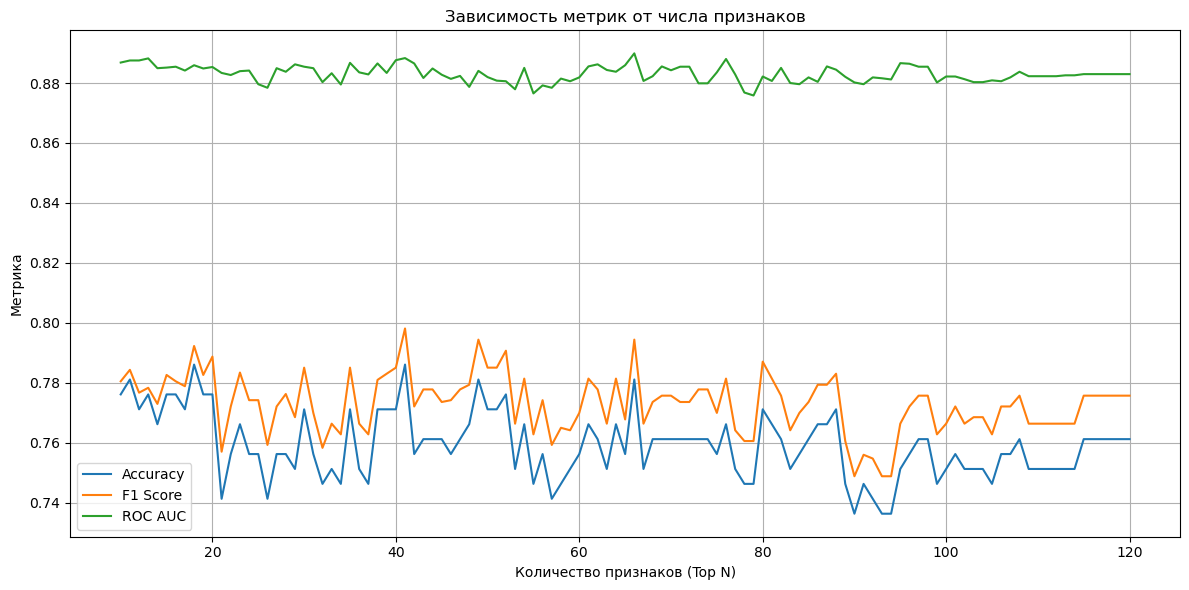


Лучшие метрики по F1:
top_n        41.000000
accuracy      0.786070
precision     0.758929
recall        0.841584
f1            0.798122
roc_auc       0.888317
Name: 31, dtype: float64


In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)
from catboost import CatBoostClassifier, CatBoostRegressor
import GPUtil
import pickle

# Проверка GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Используется CPU.")

# Загрузка модели регрессии log_IC50 из файла
try:
    with open('regression_IC50_catboost_final_model_to CC50_class.pkl', 'rb') as f:
        regression_IC50_catboost_final_model = pickle.load(f)
    print("Модель регрессии загружена из pickle файла.")
except Exception as e:
    print(f"Ошибка при загрузке модели из pickle: {e}")
    regression_IC50_catboost_final_model = CatBoostRegressor()
    regression_IC50_catboost_final_model.load_model('CC50_class.pkl')
    print("Модель регрессии загружена как бинарник CatBoost.")

# Подготовка классификатора
catboost_model = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

# === Подготовка данных ===
df = df_cut.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=[col for col in ['CC50_above_median'] if col in df.columns], inplace=True)
df.dropna(subset=["CC50_mM"], inplace=True)

# Отделяем признаки и таргет
X = df.drop(columns=["CC50_mM"])
y = df["CC50_mM"]

# === Деление на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=(y > y.median()).astype(int)
)

# Предсказание log_IC50 и добавление признака
X_train['log_IC50'] = regression_IC50_catboost_final_model.predict(X_train)
X_test['log_IC50'] = regression_IC50_catboost_final_model.predict(X_test)

# Бинаризация таргета: выше медианы — 1
median_train = y_train.median()
y_train_bin = (y_train > median_train).astype(int)
y_test_bin = (y_test > median_train).astype(int)

# === Предобработка (импутация + масштабирование) ===
imp = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

# === Получение важности признаков ===
catboost_model.fit(X_train_scaled, y_train_bin)
feature_importances = pd.Series(catboost_model.get_feature_importance(), index=X_train_scaled.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# === Цикл по количеству top-N признаков ===
results = []

for top_n in range(10, min(121, len(feature_importances) + 1), 1):
    top_features = feature_importances.head(top_n).index.tolist()
    
    X_train_sub = X_train_scaled[top_features]
    X_test_sub = X_test_scaled[top_features]

    model = CatBoostClassifier(
        task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
        depth=6,
        iterations=100,
        l2_leaf_reg=5,
        learning_rate=0.05,
        verbose=0,
        random_state=42,
        thread_count=6
    )

    model.fit(X_train_sub, y_train_bin)

    y_pred = model.predict(X_test_sub)
    y_proba = model.predict_proba(X_test_sub)[:, 1]

    results.append({
        'top_n': top_n,
        'accuracy': accuracy_score(y_test_bin, y_pred),
        'precision': precision_score(y_test_bin, y_pred),
        'recall': recall_score(y_test_bin, y_pred),
        'f1': f1_score(y_test_bin, y_pred),
        'roc_auc': roc_auc_score(y_test_bin, y_proba)
    })

# === Визуализация ===
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
plt.plot(results_df['top_n'], results_df['accuracy'], label='Accuracy')
plt.plot(results_df['top_n'], results_df['f1'], label='F1 Score')
plt.plot(results_df['top_n'], results_df['roc_auc'], label='ROC AUC')
plt.xlabel('Количество признаков (Top N)')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от числа признаков')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Лучшая модель по F1 ===
best_result = results_df.loc[results_df['f1'].idxmax()]
print("\nЛучшие метрики по F1:")
print(best_result)


по 20 важным признакам


GPU доступен.
Модель регрессии загружена из pickle файла.

Топ-25 важных признаков с их значениями важности:
log_IC50             34.873443
EState_VSA3           4.014252
VSA_EState3           2.461003
BalabanJ              2.385840
EState_VSA8           2.194058
VSA_EState7           1.971595
CSP3_Kappa1_ratio     1.935150
BCUT2D_MWLOW          1.887386
BCUT2D_CHGLO          1.453041
fr_Imine              1.340545
VSA_EState5           1.283239
VSA_EState8           1.255336
FractionCSP3          1.241774
EState_VSA2           1.239267
SMR_VSA5              1.202407
NHOHCount             1.194345
SlogP_VSA2            1.165091
VSA_EState1           1.108615
MinPartialCharge      1.097543
fr_allylic_oxid       1.080500
BCUT2D_LOGPLOW        1.074349
qed                   1.065025
fr_bicyclic           1.038473
PEOE_VSA_max          1.005586
EState_VSA10          0.966451
dtype: float64

=== Classification Report на тестовой выборке (только топ-20 признаков) ===
              precision

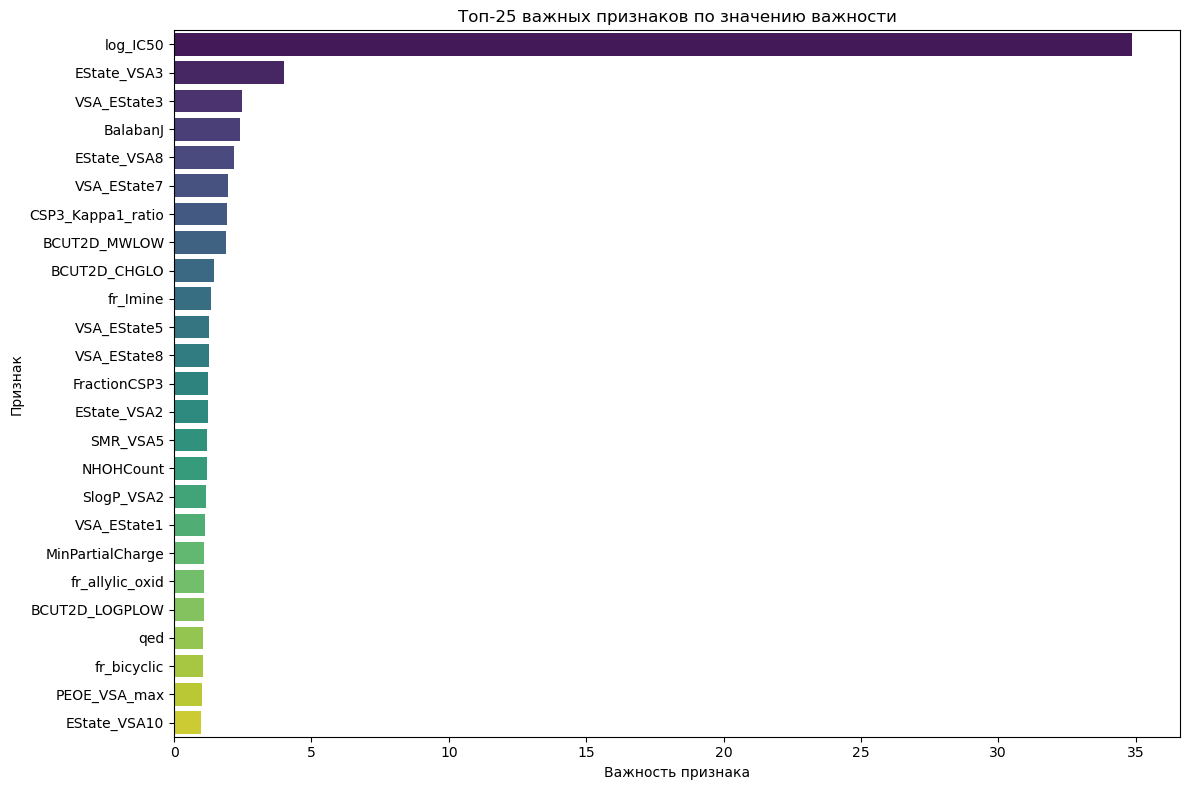

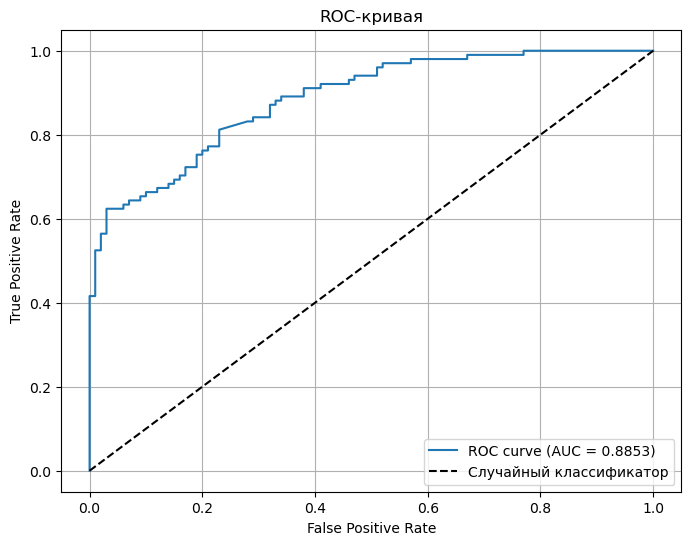

In [129]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve
)
from catboost import CatBoostClassifier, CatBoostRegressor
import GPUtil
import pickle

# Проверка GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Используется CPU.")

# Загрузка модели регрессии log_IC50 из файла
try:
    with open('regression_IC50_catboost_final_model_to CC50_class.pkl', 'rb') as f:
        regression_IC50_catboost_final_model = pickle.load(f)
    print("Модель регрессии загружена из pickle файла.")
except Exception as e:
    print(f"Ошибка при загрузке модели из pickle: {e}")
    regression_IC50_catboost_final_model = CatBoostRegressor()
    regression_IC50_catboost_final_model.load_model('CC50_class.pkl')
    print("Модель регрессии загружена как бинарник CatBoost.")

# Подготовка классификатора
catboost_model = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

# === Подготовка данных ===
df = df_cut.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=[col for col in ['CC50_above_median'] if col in df.columns], inplace=True)
df.dropna(subset=["CC50_mM"], inplace=True)

# Отделяем признаки и таргет
X = df.drop(columns=["CC50_mM"])
y = df["CC50_mM"]

# === Деление на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=(y > y.median()).astype(int)
)

# Предсказание log_IC50 и добавление признака
X_train['log_IC50'] = regression_IC50_catboost_final_model.predict(X_train)
X_test['log_IC50'] = regression_IC50_catboost_final_model.predict(X_test)

# Бинаризация таргета: выше медианы — 1
median_train = y_train.median()
y_train_bin = (y_train > median_train).astype(int)
y_test_bin = (y_test > median_train).astype(int)  # медиана от train!

# === Предобработка (импутация + масштабирование) ===
imp = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

# === Обучаем модель на всех признаках для получения важности ===
catboost_model.fit(X_train_scaled, y_train_bin)

# Получаем важности признаков
feature_importances = pd.Series(catboost_model.get_feature_importance(), index=X_train_scaled.columns)

# Выводим топ-25 признаков с их важностями
top_25_features = feature_importances.sort_values(ascending=False).head(25)
print("\nТоп-25 важных признаков с их значениями важности:")
print(top_25_features)

# Получаем топ-20 признаков по важности для обучения
top_20_features = top_25_features.head(20).index.tolist()

# Оставляем только топ-20 признаков
X_train_top20 = X_train_scaled[top_20_features]
X_test_top20 = X_test_scaled[top_20_features]

# === Обучение и предсказание только на топ-20 признаках ===
catboost_model.fit(X_train_top20, y_train_bin)

y_pred = catboost_model.predict(X_test_top20)
y_proba = catboost_model.predict_proba(X_test_top20)[:, 1]

# === Метрики ===
print("\n=== Classification Report на тестовой выборке (только топ-20 признаков) ===")
print(classification_report(y_test_bin, y_pred))

print(f"Accuracy:  {accuracy_score(y_test_bin, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_bin, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test_bin, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test_bin, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test_bin, y_proba):.4f}")

# Визуализация топ-25 важных признаков
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_25_features.values,
    y=top_25_features.index,
    palette='viridis'
)
plt.title('Топ-25 важных признаков по значению важности')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# --- ROC-кривая ---
fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test_bin, y_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


калибровка Платта


GPU доступен.
Модель регрессии загружена из pickle файла.

Топ-25 важных признаков с их значениями важности:
log_IC50             34.873443
EState_VSA3           4.014252
VSA_EState3           2.461003
BalabanJ              2.385840
EState_VSA8           2.194058
VSA_EState7           1.971595
CSP3_Kappa1_ratio     1.935150
BCUT2D_MWLOW          1.887386
BCUT2D_CHGLO          1.453041
fr_Imine              1.340545
VSA_EState5           1.283239
VSA_EState8           1.255336
FractionCSP3          1.241774
EState_VSA2           1.239267
SMR_VSA5              1.202407
NHOHCount             1.194345
SlogP_VSA2            1.165091
VSA_EState1           1.108615
MinPartialCharge      1.097543
fr_allylic_oxid       1.080500
BCUT2D_LOGPLOW        1.074349
qed                   1.065025
fr_bicyclic           1.038473
PEOE_VSA_max          1.005586
EState_VSA10          0.966451
dtype: float64

=== Classification Report на тестовой выборке (только топ-20 признаков) ===
              precision

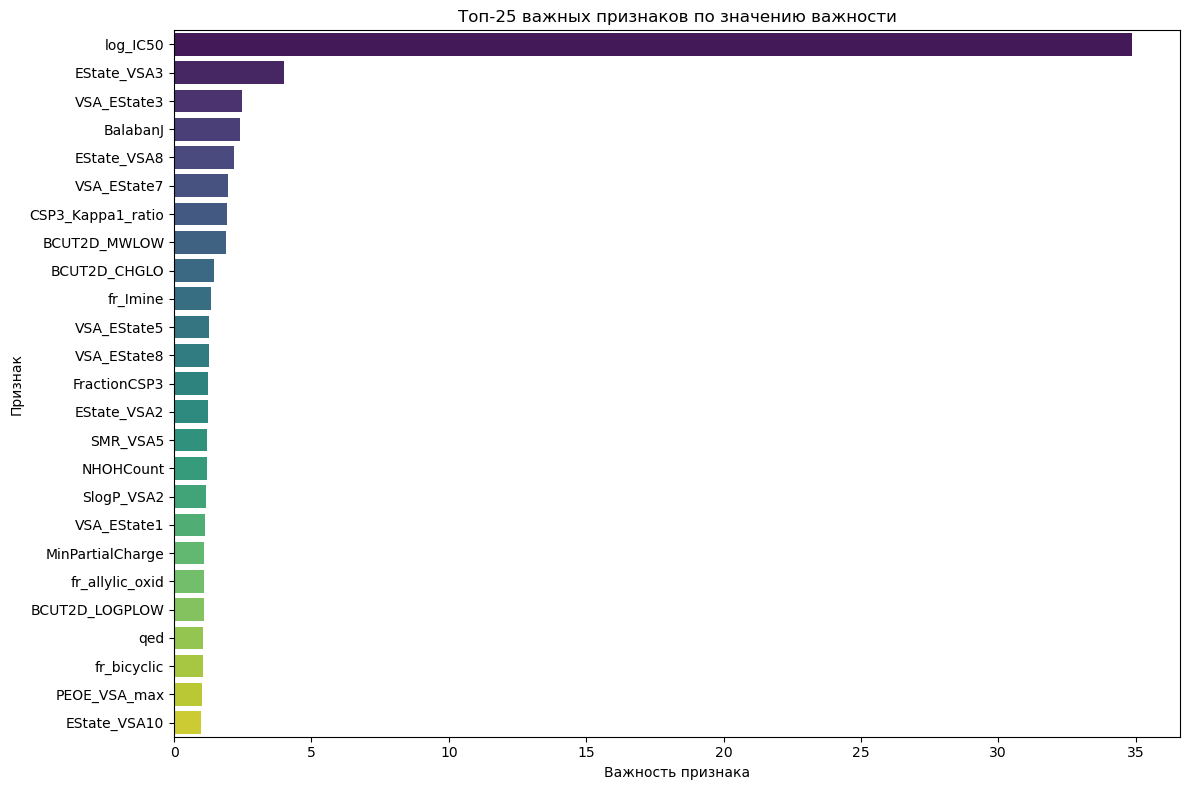

In [127]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier, CatBoostRegressor
import GPUtil
import pickle

# Проверка GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Используется CPU.")

# Загрузка модели регрессии log_IC50 из файла
try:
    with open('regression_IC50_catboost_final_model_to CC50_class.pkl', 'rb') as f:
        regression_IC50_catboost_final_model = pickle.load(f)
    print("Модель регрессии загружена из pickle файла.")
except Exception as e:
    print(f"Ошибка при загрузке модели из pickle: {e}")
    regression_IC50_catboost_final_model = CatBoostRegressor()
    regression_IC50_catboost_final_model.load_model('CC50_class.pkl')
    print("Модель регрессии загружена как бинарник CatBoost.")

# Подготовка классификатора
catboost_model = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

# === Подготовка данных ===
df = df_cut.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=[col for col in ['CC50_above_median'] if col in df.columns], inplace=True)
df.dropna(subset=["CC50_mM"], inplace=True)

# Отделяем признаки и таргет
X = df.drop(columns=["CC50_mM"])
y = df["CC50_mM"]

# === Деление на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=(y > y.median()).astype(int)
)

# Предсказание log_IC50 и добавление признака
X_train['log_IC50'] = regression_IC50_catboost_final_model.predict(X_train)
X_test['log_IC50'] = regression_IC50_catboost_final_model.predict(X_test)

# Бинаризация таргета: выше медианы — 1
median_train = y_train.median()
y_train_bin = (y_train > median_train).astype(int)
y_test_bin = (y_test > median_train).astype(int)  # медиана от train!

# === Предобработка (импутация + масштабирование) ===
imp = SimpleImputer(strategy='mean')
scaler = RobustScaler()

X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test.columns)

# === Обучаем модель на всех признаках для получения важности ===
catboost_model.fit(X_train_scaled, y_train_bin)

# Получаем важности признаков
feature_importances = pd.Series(catboost_model.get_feature_importance(), index=X_train_scaled.columns)

# Выводим топ-25 признаков с их важностями
top_25_features = feature_importances.sort_values(ascending=False).head(25)
print("\nТоп-25 важных признаков с их значениями важности:")
print(top_25_features)

# Получаем топ-20 признаков по важности для обучения
top_20_features = top_25_features.head(20).index.tolist()

# Оставляем только топ-20 признаков
X_train_top20 = X_train_scaled[top_20_features]
X_test_top20 = X_test_scaled[top_20_features]

# === Обучение только на топ-20 признаках ===
catboost_model.fit(X_train_top20, y_train_bin)

# Калибровка вероятностей с помощью метода Платта (sigmoid)
calibrated_clf = CalibratedClassifierCV(estimator=catboost_model, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_train_top20, y_train_bin)

# Предсказания с откалиброванными вероятностями
y_pred = calibrated_clf.predict(X_test_top20)
y_proba = calibrated_clf.predict_proba(X_test_top20)[:, 1]

# === Метрики ===
print("\n=== Classification Report на тестовой выборке (только топ-20 признаков) ===")
print(classification_report(y_test_bin, y_pred))

print(f"Accuracy:  {accuracy_score(y_test_bin, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_bin, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test_bin, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test_bin, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test_bin, y_proba):.4f}")

# Визуализация топ-25 важных признаков
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_25_features.values,
    y=top_25_features.index,
    palette='viridis'
)
plt.title('Топ-25 важных признаков по значению важности')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()


In [97]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier, Pool
from matplotlib.backends.backend_pdf import PdfPages
import GPUtil

# Проверка GPU
if GPUtil.getGPUs():
    print("\nGPU доступен. CatBoost будет использовать GPU.")
    task_type = 'GPU'
else:
    print("\nGPU не обнаружен. CatBoost будет использовать CPU.")
    task_type = 'CPU'

# Предобработка датафрейма
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)

# CatBoost модель
catboost_model = CatBoostClassifier(
    task_type=task_type,
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
)

class_models = {
    "CatBoost": catboost_model
}

def evaluate_catboost_model(df_input, y_col='CC50_above_median'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X = df_eval.drop(columns=[y_col])
    y = df_eval[y_col]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        try:
            cv_results = cross_validate(
                model, X_scaled, y,
                cv=kf,
                scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                return_train_score=False,
                n_jobs=1
            )
            results.append({
                "Model": name,
                "Accuracy": np.mean(cv_results['test_accuracy']),
                "Precision": np.mean(cv_results['test_precision']),
                "Recall": np.mean(cv_results['test_recall']),
                "F1": np.mean(cv_results['test_f1']),
                "ROC AUC": np.mean(cv_results['test_roc_auc'])
            })
        except Exception as e:
            print(f"Ошибка в модели {name}: {e}")
    return pd.DataFrame(results), X_scaled, y, imputer, scaler

# Оценка модели CatBoost на df_cut
results_cut, X_cut_scaled, y_cut, imp, scaler = evaluate_catboost_model(df_cut)
results_cut['Dataset'] = 'df_cut'

# Генерация отчёта PDF
with PdfPages('classification_evaluation_catboost_df_cut.pdf') as pdf:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=results_cut, x='F1', y='Model', palette='Set2')
    plt.title("CatBoost F1 Score on df_cut")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(8, 5))
    sns.barplot(data=results_cut, x='ROC AUC', y='Model', palette='Set1')
    plt.title("CatBoost ROC AUC on df_cut")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ROC-кривая
    model = catboost_model
    X_train, X_test, y_train, y_test = train_test_split(X_cut_scaled, y_cut, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("ROC Curve - df_cut (CatBoost)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    pdf.savefig()
    plt.close()

    # Важность признаков
    try:
        importances = model.get_feature_importance(Pool(X_cut_scaled, label=y_cut))
        feature_names = X_cut_scaled.columns

        feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
        plt.title("Top 20 Feature Importances - CatBoost (df_cut)")
        plt.tight_layout()
        pdf.savefig()
        plt.close()
    except Exception as e:
        print(f"[!] Невозможно построить важность признаков: {e}")

# Сохранение в Excel
results_cut.to_excel("catboost_classification_metrics_df_cut.xlsx", index=False)



GPU доступен. CatBoost будет использовать GPU.


Cross-validation (157 features): 100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from matplotlib.backends.backend_pdf import PdfPages
import GPUtil

# Проверка использования GPU
gpu_models = []
if GPUtil.getGPUs():
    print("\nGPU доступен. Будет использоваться для XGBoost, LightGBM и CatBoost.")
    gpu_models = ["XGBoost", "LightGBM", "CatBoost"]
else:
    print("\nGPU не обнаружен. Все модели будут работать на CPU.")

# Очистка имен и замена inf на nan
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# GPU-оптимизированные модели
xgb_gpu = XGBClassifier(tree_method='gpu_hist' if "XGBoost" in gpu_models else 'auto',
                        random_state=42, use_label_encoder=False,
                        eval_metric='logloss', n_jobs=1)

lgbm_gpu = LGBMClassifier(device='gpu' if "LightGBM" in gpu_models else 'cpu',
                          random_state=42, n_jobs=1)

catboost_gpu = CatBoostClassifier(
    task_type='GPU' if "CatBoost" in gpu_models else 'CPU',
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42,
    thread_count=6
    )

# Стэкинг
estimators_cls = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=1)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', xgb_gpu),
    ('cat', catboost_gpu)
]

final_estimator_cls = LogisticRegression()
stacking_model_cls = StackingClassifier(
    estimators=estimators_cls,
    final_estimator=final_estimator_cls,
    cv=5,
    n_jobs=1
)

# Словарь моделей
class_models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_jobs=1),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb_gpu,
    "LightGBM": lgbm_gpu,
    "CatBoost": catboost_gpu,
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Stacking": stacking_model_cls
}

def evaluate_class_models(df_input, y_col='CC50_above_median'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X = df_eval.drop(columns=[y_col])
    y = df_eval[y_col]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        try:
            cv_results = cross_validate(
                model, X_scaled, y,
                cv=kf,
                scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                return_train_score=False,
                n_jobs=1  # Отключаем параллельность
            )
            results.append({
                "Model": name,
                "Accuracy": np.mean(cv_results['test_accuracy']),
                "Precision": np.mean(cv_results['test_precision']),
                "Recall": np.mean(cv_results['test_recall']),
                "F1": np.mean(cv_results['test_f1']),
                "ROC AUC": np.mean(cv_results['test_roc_auc'])
            })
        except Exception as e:
            print(f"Error in model {name}: {e}")
    return pd.DataFrame(results).sort_values(by="F1", ascending=False), X_scaled, y, imputer, scaler

# Запуск для всех датасетов
results_df, X_df_scaled, y_df, imp_df, scaler_df = evaluate_class_models(df)
results_df['Dataset'] = 'df'

results_cut, X_cut_scaled, y_cut, _, _ = evaluate_class_models(df_cut)
results_cut['Dataset'] = 'df_cut'

results_bin, X_bin_scaled, y_bin, _, _ = evaluate_class_models(df_bin)
results_bin['Dataset'] = 'df_bin'

results_cut_bin, X_cut_bin_scaled, y_cut_bin, _, _ = evaluate_class_models(df_cut_bin)
results_cut_bin['Dataset'] = 'df_cut_bin'

comparison_cls = pd.concat([results_df, results_cut, results_bin, results_cut_bin], ignore_index=True)

# Отчёты
with PdfPages('classification_evaluation_report_CC50.pdf') as pdf:
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='F1', y='Model', hue='Dataset', palette='Set2')
    plt.title("Model F1 Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='ROC AUC', y='Model', hue='Dataset', palette='Set1')
    plt.title("Model ROC AUC Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    for name, (X_scaled, y) in zip(['df', 'df_cut', 'df_bin', 'df_cut_bin'],
                                   [(X_df_scaled, y_df), (X_cut_scaled, y_cut), (X_bin_scaled, y_bin), (X_cut_bin_scaled, y_cut_bin)]):
        best_model_name = comparison_cls[comparison_cls['Dataset'] == name].iloc[0]['Model']
        model = class_models[best_model_name]
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        pdf.savefig()
        plt.close()

        try:
            if hasattr(model, 'get_feature_importance'):
                importances = model.get_feature_importance(Pool(X_scaled, label=y))
            elif hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                continue

            feature_names = X_scaled.columns
            if len(importances) != len(feature_names):
                min_len = min(len(importances), len(feature_names))
                importances = importances[:min_len]
                feature_names = feature_names[:min_len]

            feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
            plt.title(f"Top 20 Feature Importances - {best_model_name} ({name})")
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        except Exception as e:
            print(f"[!] Could not plot feature importances for {best_model_name} ({name}): {e}")

# Excel сохранение
with pd.ExcelWriter("classification_comparison_metrics_CC50.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="df", index=False)
    results_cut.to_excel(writer, sheet_name="df_cut", index=False)
    results_bin.to_excel(writer, sheet_name="df_bin", index=False)
    results_cut_bin.to_excel(writer, sheet_name="df_cut_bin", index=False)
    comparison_cls.to_excel(writer, sheet_name="Comparison", index=False)



GPU доступен. Будет использоваться для XGBoost, LightGBM и CatBoost.


Cross-validation (232 features):  54%|█████▍    | 7/13 [00:47<00:40,  6.80s/it]

[LightGBM] [Info] Number of positive: 394, number of negative: 406
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 26714
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 206
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 151 dense feature groups (0.12 MB) transferred to GPU in 0.002453 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492500 -> initscore=-0.030002
[LightGBM] [Info] Start training from score -0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 399, number of negative: 402
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM]

Cross-validation (232 features):  62%|██████▏   | 8/13 [01:05<00:52, 10.54s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Cross-validation (160 features):  54%|█████▍    | 7/13 [00:28<00:25,  4.23s/it]

[LightGBM] [Info] Number of positive: 394, number of negative: 406
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 14008
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 135
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 86 dense feature groups (0.07 MB) transferred to GPU in 0.001188 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492500 -> initscore=-0.030002
[LightGBM] [Info] Start training from score -0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

Cross-validation (232 features):  54%|█████▍    | 7/13 [00:44<00:39,  6.65s/it]

[LightGBM] [Info] Number of positive: 394, number of negative: 406
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 26381
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 161
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (0.12 MB) transferred to GPU in 0.001781 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492500 -> initscore=-0.030002
[LightGBM] [Info] Start training from score -0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Cross-validation (97 features):  54%|█████▍    | 7/13 [00:24<00:21,  3.62s/it]

[LightGBM] [Info] Number of positive: 394, number of negative: 406
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 95
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 84 dense feature groups (0.06 MB) transferred to GPU in 0.001359 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492500 -> initscore=-0.030002
[LightGBM] [Info] Start training from score -0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

Cross-validation (97 features): 100%|██████████| 13/13 [02:47<00:00, 12.87s/it]


[LightGBM] [Info] Number of positive: 394, number of negative: 406
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 26714
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 206
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 151 dense feature groups (0.12 MB) transferred to GPU in 0.001757 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492500 -> initscore=-0.030002
[LightGBM] [Info] Start training from score -0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from matplotlib.backends.backend_pdf import PdfPages

# Очистка имен и замена inf на nan
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# Определение базовых моделей классификации
estimators_cls = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('cat', CatBoostClassifier(verbose=0, random_state=42))
]

final_estimator_cls = LogisticRegression()
stacking_model_cls = StackingClassifier(
    estimators=estimators_cls,
    final_estimator=final_estimator_cls,
    cv=5,
    n_jobs=-1
)

class_models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost":CatBoostClassifier(
    depth=6,
    iterations=100,
    l2_leaf_reg=5,
    learning_rate=0.05,
    verbose=0,
    random_state=42
    ),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Stacking": stacking_model_cls
}


def evaluate_class_models(df_input, y_col='CC50_above_median'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    X = df_eval.drop(columns=[y_col])
    y = df_eval[y_col]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        try:
            cv_results = cross_validate(
                model, X_scaled, y,
                cv=kf,
                scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                return_train_score=False,
                n_jobs=-1
            )
            results.append({
                "Model": name,
                "Accuracy": np.mean(cv_results['test_accuracy']),
                "Precision": np.mean(cv_results['test_precision']),
                "Recall": np.mean(cv_results['test_recall']),
                "F1": np.mean(cv_results['test_f1']),
                "ROC AUC": np.mean(cv_results['test_roc_auc'])
            })
        except Exception as e:
            print(f"Error in model {name}: {e}")
    return pd.DataFrame(results).sort_values(by="F1", ascending=False), X_scaled, y, imputer, scaler

results_df, X_df_scaled, y_df, imp_df, scaler_df = evaluate_class_models(df)
results_df['Dataset'] = 'df'

results_cut, X_cut_scaled, y_cut, _, _ = evaluate_class_models(df_cut)
results_cut['Dataset'] = 'df_cut'

results_bin, X_bin_scaled, y_bin, _, _ = evaluate_class_models(df_bin)
results_bin['Dataset'] = 'df_bin'

results_cut_bin, X_cut_bin_scaled, y_cut_bin, _, _ = evaluate_class_models(df_cut_bin)
results_cut_bin['Dataset'] = 'df_cut_bin'

comparison_cls = pd.concat([results_df, results_cut, results_bin, results_cut_bin], ignore_index=True)

with PdfPages('classification_evaluation_report_CC50.pdf') as pdf:
    # F1
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='F1', y='Model', hue='Dataset', palette='Set2')
    plt.title("Model F1 Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ROC AUC
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='ROC AUC', y='Model', hue='Dataset', palette='Set1')
    plt.title("Model ROC AUC Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ROC-кривые и важности признаков
    for name, (X_scaled, y) in zip(['df', 'df_cut', 'df_bin', 'df_cut_bin'],
                                   [(X_df_scaled, y_df), (X_cut_scaled, y_cut), (X_bin_scaled, y_bin), (X_cut_bin_scaled, y_cut_bin)]):
        best_model_name = comparison_cls[comparison_cls['Dataset'] == name].iloc[0]['Model']
        model = class_models[best_model_name]
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        pdf.savefig()
        plt.close()

        # Важность признаков
        try:
            if hasattr(model, 'get_feature_importance'):
                importances = model.get_feature_importance(Pool(X_scaled, label=y))
            elif hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                continue

            feature_names = X_scaled.columns
            if len(importances) != len(feature_names):
                min_len = min(len(importances), len(feature_names))
                importances = importances[:min_len]
                feature_names = feature_names[:min_len]

            feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
            plt.title(f"Top 20 Feature Importances - {best_model_name} ({name})")
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        except Exception as e:
            print(f"[!] Could not plot feature importances for {best_model_name} ({name}): {e}")

with pd.ExcelWriter("classification_comparison_metrics_CC50.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="df", index=False)
    results_cut.to_excel(writer, sheet_name="df_cut", index=False)
    results_bin.to_excel(writer, sheet_name="df_bin", index=False)
    results_cut_bin.to_excel(writer, sheet_name="df_cut_bin", index=False)
    comparison_cls.to_excel(writer, sheet_name="Comparison", index=False)


Cross-validation (94 features): 100%|██████████| 13/13 [03:48<00:00, 17.56s/it]


 Запуск RandomizedSearchCV...


RandomizedSearchCV:   0%|          | 0/1 [00:00<?, ?it/s]

0:	learn: 0.6410867	total: 17.7ms	remaining: 8.28s
469:	learn: 0.0222045	total: 7.18s	remaining: 0us
0:	learn: 0.6524474	total: 16.4ms	remaining: 7.67s
469:	learn: 0.0303789	total: 6.97s	remaining: 0us
0:	learn: 0.6482809	total: 15.2ms	remaining: 7.14s
469:	learn: 0.0204381	total: 6.93s	remaining: 0us
0:	learn: 0.6125969	total: 9.53ms	remaining: 3.94s
413:	learn: 0.0059528	total: 3.71s	remaining: 0us
0:	learn: 0.6201361	total: 9.79ms	remaining: 4.04s
413:	learn: 0.0087879	total: 3.64s	remaining: 0us
0:	learn: 0.6071948	total: 9.9ms	remaining: 4.09s
413:	learn: 0.0057144	total: 3.8s	remaining: 0us
0:	learn: 0.6223659	total: 10.6ms	remaining: 3.69s
348:	learn: 0.0091792	total: 3.35s	remaining: 0us
0:	learn: 0.6308859	total: 12ms	remaining: 4.16s
348:	learn: 0.0125494	total: 3.31s	remaining: 0us
0:	learn: 0.6241499	total: 9.98ms	remaining: 3.47s
348:	learn: 0.0087076	total: 3.25s	remaining: 0us
0:	learn: 0.6466216	total: 8.91ms	remaining: 3.48s
390:	learn: 0.0607576	total: 3.16s	remaining

RandomizedSearchCV: 100%|██████████| 1/1 [34:46<00:00, 2086.87s/it]


469:	learn: 0.0329610	total: 8.35s	remaining: 0us
 Параметры после RandomizedSearchCV:
{'bagging_temperature': 0.3745401188473625, 'depth': 8, 'iterations': 470, 'l2_leaf_reg': 8.31993941811405, 'learning_rate': 0.06986584841970366}

 Запуск GridSearchCV...


GridSearchCV:   0%|          | 0/1 [00:00<?, ?it/s]

0:	learn: 0.6422694	total: 12.2ms	remaining: 5.12s
419:	learn: 0.0257229	total: 4.93s	remaining: 0us
0:	learn: 0.6497594	total: 13.9ms	remaining: 5.83s
419:	learn: 0.0201439	total: 4.92s	remaining: 0us
0:	learn: 0.6326519	total: 12.8ms	remaining: 5.36s
419:	learn: 0.0226407	total: 4.64s	remaining: 0us
0:	learn: 0.6415479	total: 11.7ms	remaining: 4.88s
419:	learn: 0.0168501	total: 4.45s	remaining: 0us
0:	learn: 0.6443573	total: 11.7ms	remaining: 4.89s
419:	learn: 0.0287378	total: 4.61s	remaining: 0us
0:	learn: 0.6524661	total: 13.6ms	remaining: 5.7s
419:	learn: 0.0236669	total: 5.04s	remaining: 0us
0:	learn: 0.6351168	total: 15.1ms	remaining: 6.31s
419:	learn: 0.0244422	total: 4.73s	remaining: 0us
0:	learn: 0.6447412	total: 11.9ms	remaining: 4.99s
419:	learn: 0.0195575	total: 4.58s	remaining: 0us
0:	learn: 0.6422694	total: 14ms	remaining: 6.57s
469:	learn: 0.0227584	total: 5.11s	remaining: 0us
0:	learn: 0.6497594	total: 11.7ms	remaining: 5.47s
469:	learn: 0.0173649	total: 5.07s	remainin

GridSearchCV: 100%|██████████| 1/1 [1:16:47<00:00, 4607.83s/it]

419:	learn: 0.0456818	total: 5.63s	remaining: 0us
 Точно подобранные параметры (GridSearchCV):
{'bagging_temperature': 0.37, 'depth': 7, 'iterations': 420, 'l2_leaf_reg': 8.3, 'learning_rate': 0.07}

 Классификационный отчет:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       101
           1       0.82      0.85      0.83       100

    accuracy                           0.83       201
   macro avg       0.83      0.83      0.83       201
weighted avg       0.83      0.83      0.83       201

Accuracy: 0.8308
ROC AUC:  0.9134

 Результаты сохранены в CC50_results_classification.json и .csv


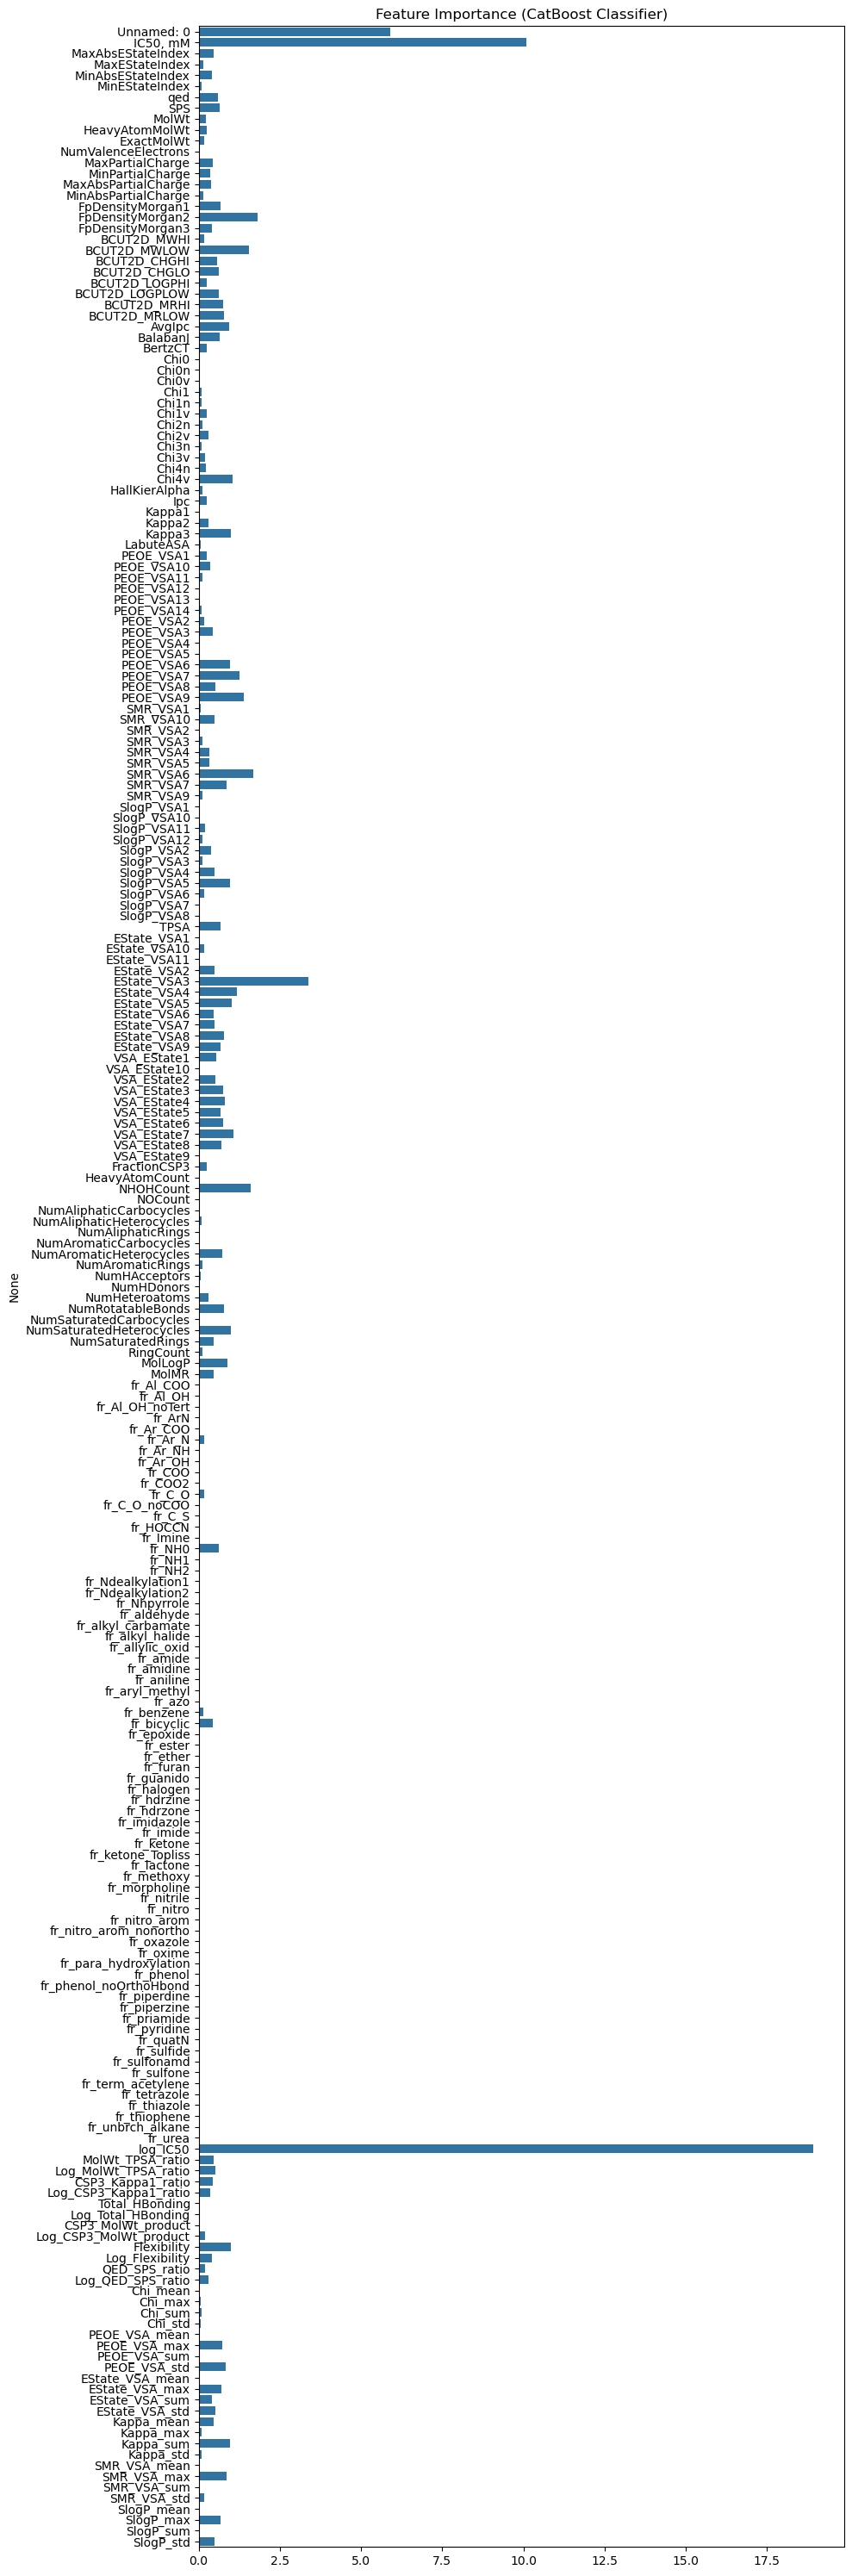

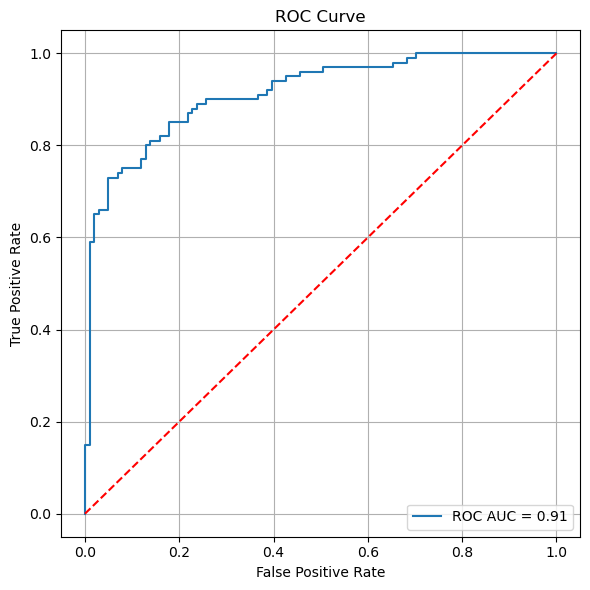

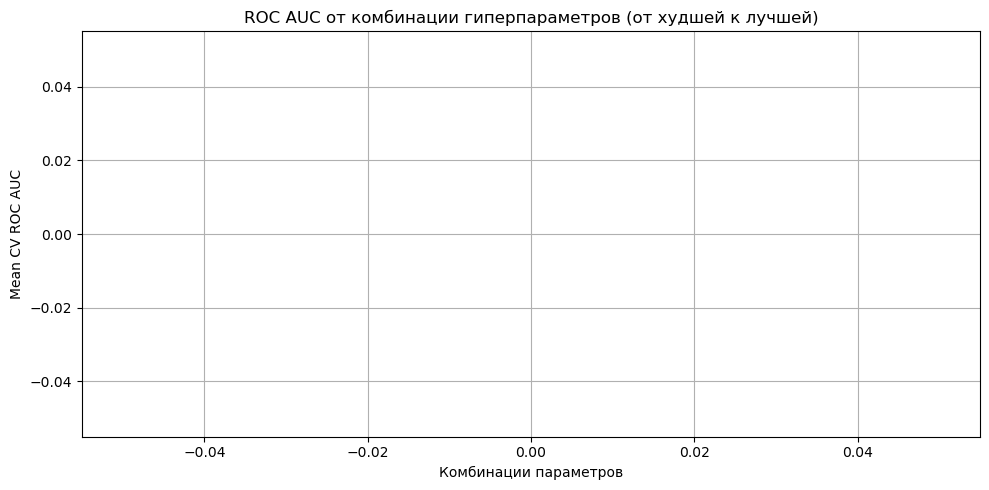


--- Выводы и интерпретация ---
 Accuracy на тесте: 0.8308
 ROC AUC на тесте: 0.9134

 Топ-5 признаков по важности:
1. log_IC50: 18.9305
2. IC50, mM: 10.0762
3. Unnamed: 0: 5.8868
4. EState_VSA3: 3.3713
5. FpDensityMorgan2: 1.8040

 Модель показала отличное качество классификации (ROC AUC = 0.913).
 Разница между train и CV AUC незначительная — переобучение маловероятно.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    accuracy_score,
    make_scorer,
    roc_curve
)
from scipy.stats import randint, uniform
from catboost import CatBoostClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# --- 1. Данные и подготовка ---
X = df_bin.drop(columns=['CC50_above_median'])
y = df_bin['CC50_above_median']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Базовая модель ---
base_model = CatBoostClassifier(
    verbose=500,
    random_state=42,
    task_type='GPU',
    thread_count=6
)

# --- 3. Метрики ---
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# --- 4. RandomizedSearchCV ---
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.1),
    'iterations': randint(200, 600),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
}

print(" Запуск RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=1,
    return_train_score=True
)

with tqdm(total=1, desc="RandomizedSearchCV") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)

print(" Параметры после RandomizedSearchCV:")
print(random_search.best_params_)

# --- 5. GridSearchCV — тонкая настройка ---
best_params = random_search.best_params_

param_grid = {
    'depth': list(set([max(1, best_params['depth'] - 1), best_params['depth'], best_params['depth'] + 1])),
    'learning_rate': [round(best_params['learning_rate'] * r, 3) for r in [1.0, 1.2]],  # 2 варианта вместо 3
    'iterations': [best_params['iterations'] - 50, best_params['iterations'], best_params['iterations'] + 50],  # уменьшил шаг
    'l2_leaf_reg': [round(best_params['l2_leaf_reg'] * r, 1) for r in [1.0, 1.2]],
    'bagging_temperature': [round(best_params['bagging_temperature'] * r, 2) for r in [1.0, 1.2]]
}

for key, vals in param_grid.items():
    param_grid[key] = sorted(list(set([v for v in vals if v >= 0])))

print("\n Запуск GridSearchCV...")
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=2,
    n_jobs=1,
    return_train_score=True
)

with tqdm(total=1, desc="GridSearchCV") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(1)

print(" Точно подобранные параметры (GridSearchCV):")
print(grid_search.best_params_)

# --- 6. Оценка на тесте ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n Классификационный отчет:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC:  {roc_auc:.4f}")

# --- 7. Сохранение результатов ---
results = {
    "best_params_random": random_search.best_params_,
    "best_params_grid": grid_search.best_params_,
    "accuracy_test": accuracy,
    "roc_auc_test": roc_auc,
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
}

with open("CC50_results_classification.json", "w") as f:
    json.dump(results, f, indent=4)

pd.DataFrame(results["classification_report"]).transpose().to_csv("IC50_classification_report.csv")

print("\n Результаты сохранены в CC50_results_classification.json и .csv")

# --- 8. График Feature Importance ---
importances = best_model.get_feature_importance()
features = X.columns

plt.figure(figsize=(10, 30))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (CatBoost Classifier)")
plt.tight_layout()
plt.savefig("CC50_classification_feature_importance.png")
plt.show()

pd.DataFrame({'feature': features, 'importance': importances}).sort_values(
    by='importance', ascending=False
).to_csv("CC50_feature_importance.csv", index=False)

# --- 9. ROC AUC график ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_roc_curve.png")
plt.show()

# --- 10. ROC AUC от гиперпараметров ---
cv_results_auc = pd.DataFrame(grid_search.cv_results_)
auc_sorted = cv_results_auc.sort_values(by='mean_test_roc_auc')

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(auc_sorted)), y=auc_sorted['mean_test_roc_auc'])
plt.title('ROC AUC от комбинации гиперпараметров (от худшей к лучшей)')
plt.xlabel('Комбинации параметров')
plt.ylabel('Mean CV ROC AUC')
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_classifier_roc_auc_hyperparams.png")
plt.show()

# --- 11. Выводы и интерпретация ---
print("\n--- Выводы и интерпретация ---")
print(f" Accuracy на тесте: {accuracy:.4f}")
print(f" ROC AUC на тесте: {roc_auc:.4f}")

top_features = pd.Series(importances, index=features).sort_values(ascending=False)[:5]
print("\n Топ-5 признаков по важности:")
for i, (feat, val) in enumerate(top_features.items(), 1):
    print(f"{i}. {feat}: {val:.4f}")

if roc_auc > 0.9:
    perf = "отличное"
elif roc_auc > 0.8:
    perf = "очень хорошее"
elif roc_auc > 0.7:
    perf = "удовлетворительное"
else:
    perf = "недостаточное"

print(f"\n Модель показала {perf} качество классификации (ROC AUC = {roc_auc:.3f}).")

train_auc = max(grid_search.cv_results_["mean_train_roc_auc"])
cv_auc = grid_search.best_score_
gap = train_auc - cv_auc

if gap > 0.05:
    print(f" Возможное переобучение: разница между train AUC и CV AUC составляет {gap:.3f}.")
else:
    print(" Разница между train и CV AUC незначительная — переобучение маловероятно.")


- без признака IC50

Running 5-fold cross-validation without data leakage for CC50...
Fold 1 Accuracy: 0.7624, ROC AUC: 0.8827
Fold 2 Accuracy: 0.8200, ROC AUC: 0.9046
Fold 3 Accuracy: 0.7200, ROC AUC: 0.8348
Fold 4 Accuracy: 0.7400, ROC AUC: 0.8472
Fold 5 Accuracy: 0.7200, ROC AUC: 0.8081
Fold 6 Accuracy: 0.7000, ROC AUC: 0.8025
Fold 7 Accuracy: 0.7900, ROC AUC: 0.8810
Fold 8 Accuracy: 0.7700, ROC AUC: 0.8574
Fold 9 Accuracy: 0.7200, ROC AUC: 0.8463
Fold 10 Accuracy: 0.7900, ROC AUC: 0.8847

Cross-validation results:
Accuracy: 0.7532 ± 0.0372
ROC AUC:  0.8549 ± 0.0321

Train CC50 median: 410.0586
Test  CC50 median: 411.0393

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.59      0.67       101
           1       0.66      0.81      0.73       100

    accuracy                           0.70       201
   macro avg       0.71      0.70      0.70       201
weighted avg       0.71      0.70      0.70       201

Test Accuracy: 0.7015
Test ROC AUC:  

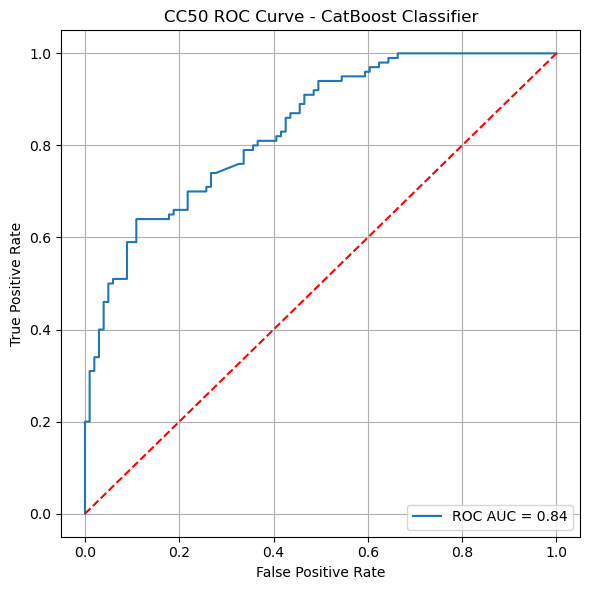

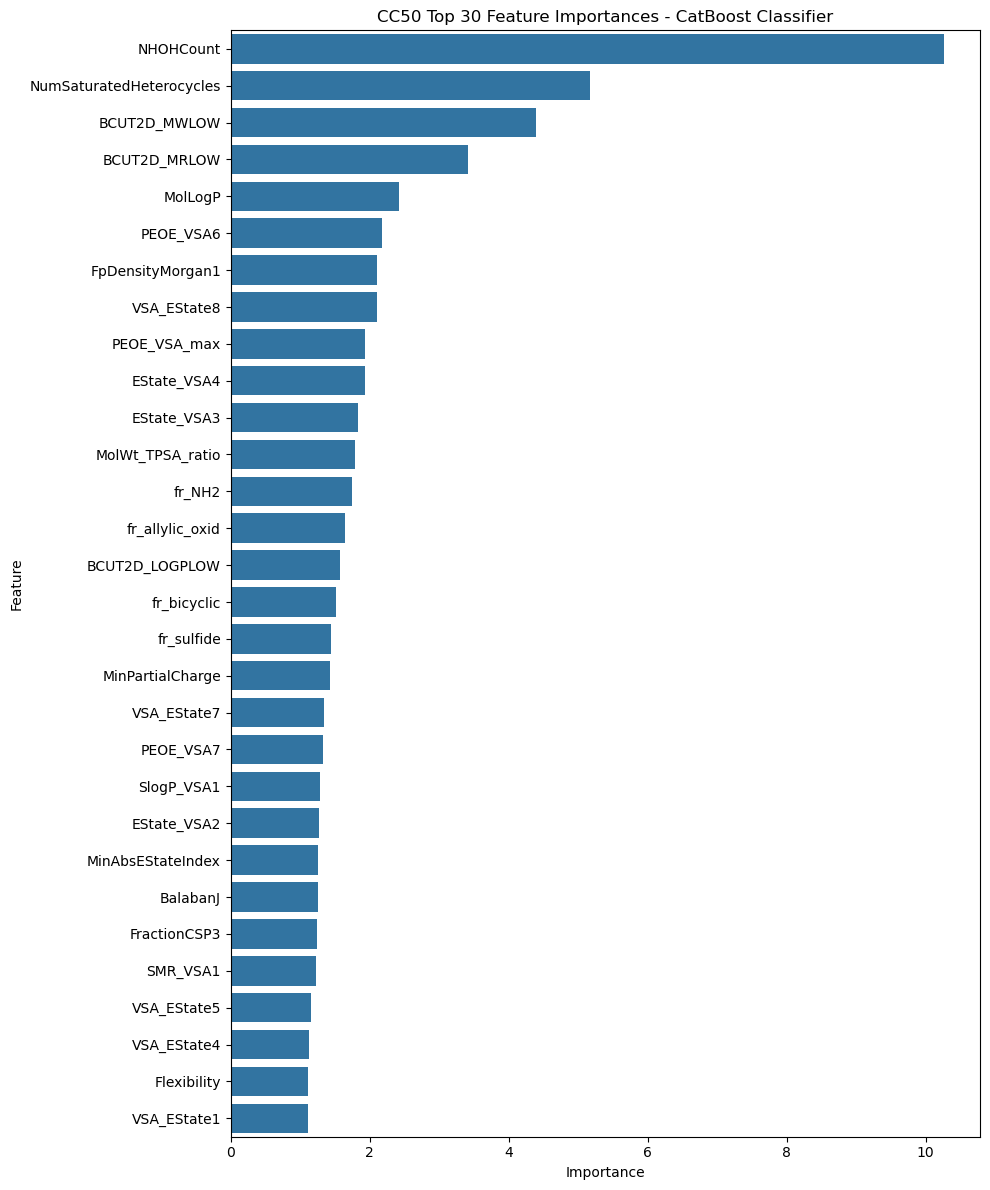


Модель сохранена как 'CC50_classifier_catboost_final_model.pkl'


In [42]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Подготовка данных ---
df = df_cut.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['CC50_above_median'], errors='ignore', inplace=True)

# Обнаружение колонки с CC50
cc50_columns = [col for col in df.columns if 'cc50' in col.lower()]
if not cc50_columns:
    raise ValueError("Нет колонки, содержащей 'CC50' в названии.")
cc50_col = cc50_columns[0]

CC50 = df[cc50_col]
X = df.drop(columns=[cc50_col])

# Импутация и масштабирование
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Кросс-валидация ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 5-fold cross-validation without data leakage for CC50...")

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    cc50_train = CC50.iloc[train_index]
    cc50_val = CC50.iloc[val_index]

    median_cc50 = cc50_train.median()
    y_train_cv = (cc50_train > median_cc50).astype(int)
    y_val_cv = (cc50_val > median_cc50).astype(int)

    # Проверка на один класс в таргете
    if y_train_cv.nunique() < 2 or y_val_cv.nunique() < 2:
        print(f"Skipping fold {fold} due to only one class in target.")
        continue

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 4. Разделение и оценка на тесте ---
median_cc50_global = CC50.median()
y_binary = (CC50 > median_cc50_global).astype(int)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y_binary, CC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

cc50_train = CC50.loc[idx_train]
cc50_test = CC50.loc[idx_test]

print(f"\nTrain CC50 median: {cc50_train.median():.4f}")
print(f"Test  CC50 median: {cc50_test.median():.4f}")

cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 5. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CC50 ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_classifier_roc_curve_classification.png")
plt.show()

# --- 6. Важность признаков ---
y_full = (CC50 > median_cc50_global).astype(int)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled, y_full)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("CC50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("CC50_classification_feature_importance.png")
plt.show()

# --- 7. Сохранение модели ---
joblib.dump(cat_model_final, 'CC50_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'CC50_classifier_catboost_final_model.pkl'")


- с добавлением предсказанного признака IC50

Running 10-fold cross-validation without data leakage for CC50...
Fold 1 Accuracy: 0.8020, ROC AUC: 0.8834
Fold 2 Accuracy: 0.8200, ROC AUC: 0.8996
Fold 3 Accuracy: 0.7300, ROC AUC: 0.8276
Fold 4 Accuracy: 0.7700, ROC AUC: 0.8411
Fold 5 Accuracy: 0.7000, ROC AUC: 0.8137
Fold 6 Accuracy: 0.7000, ROC AUC: 0.8029
Fold 7 Accuracy: 0.7700, ROC AUC: 0.8718
Fold 8 Accuracy: 0.7800, ROC AUC: 0.8709
Fold 9 Accuracy: 0.7200, ROC AUC: 0.8479
Fold 10 Accuracy: 0.7700, ROC AUC: 0.8718

Cross-validation results:
Accuracy: 0.7562 ± 0.0395
ROC AUC:  0.8531 ± 0.0300

Train CC50 median: 410.0586
Test  CC50 median: 411.0393

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       101
           1       0.69      0.79      0.74       100

    accuracy                           0.72       201
   macro avg       0.73      0.72      0.72       201
weighted avg       0.73      0.72      0.72       201

Test Accuracy: 0.7214
Test ROC AUC: 

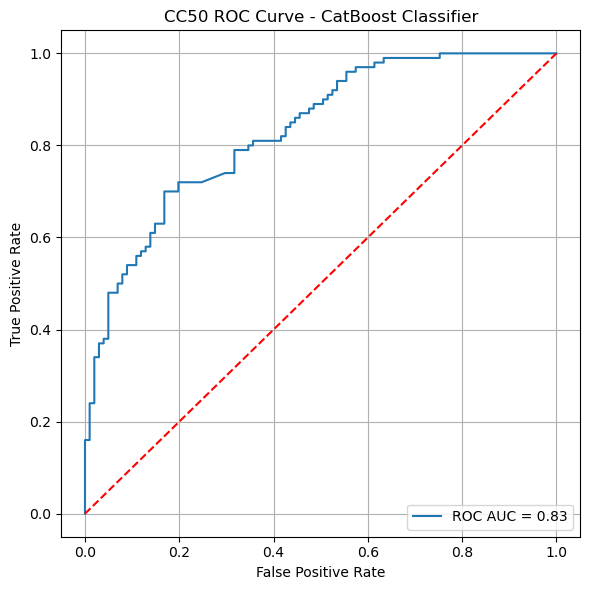

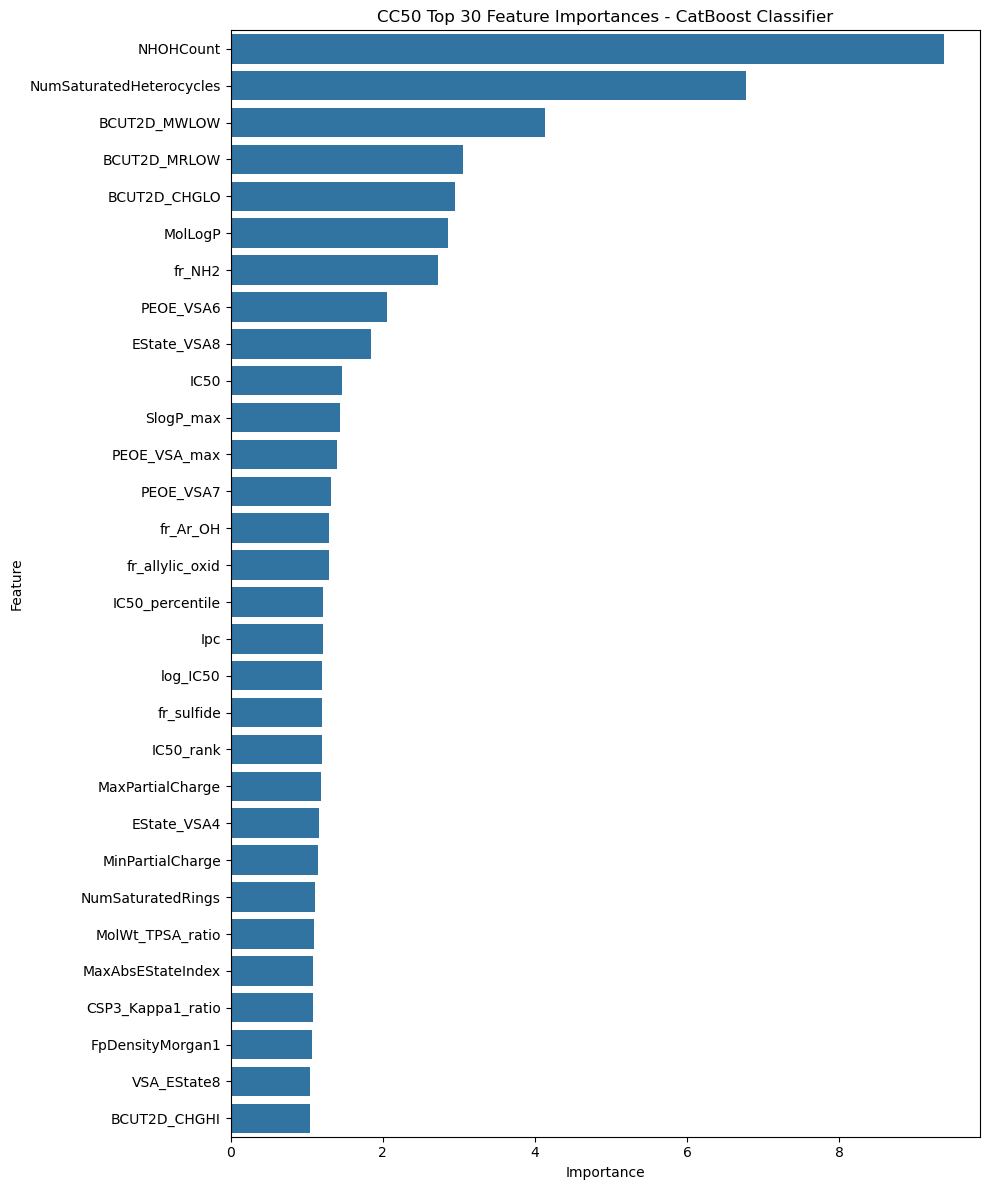


Модель сохранена как 'CC50_classifier_catboost_final_model.pkl'


In [57]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Подготовка данных ---
df = df_cut.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['CC50_above_median'], errors='ignore', inplace=True)

# --- 1.1 Добавление признака log_IC50 из регрессионной модели ---
reg_model = joblib.load('regression_IC50_catboost_final_model_to CC50_class.pkl')

# Отбираем только фичи, которые были в обучающей регрессионной модели
# (предполагаем, что структура признаков одинакова)
X_features = df.drop(columns=[col for col in df.columns if 'cc50' in col.lower()], errors='ignore')

# Импутация и масштабирование для признаков под регрессионную модель
imputer_reg = SimpleImputer(strategy='most_frequent')
X_imputed_reg = pd.DataFrame(imputer_reg.fit_transform(X_features), columns=X_features.columns)

scaler_reg = RobustScaler()
X_scaled_reg = pd.DataFrame(scaler_reg.fit_transform(X_imputed_reg), columns=X_features.columns)

# Предсказание log(IC50)
log_ic50_pred = reg_model.predict(X_scaled_reg)
df['log_IC50'] = log_ic50_pred  # Добавляем как новый признак
df['IC50'] = 10**df['log_IC50']
# Добавляем ранги
df['IC50_rank'] = df['IC50'].rank(method='average')
df['IC50_percentile'] = df['IC50'].rank(pct=True)


# --- 1.2 Обнаружение и обработка CC50 ---
cc50_columns = [col for col in df.columns if 'cc50' in col.lower()]
if not cc50_columns:
    raise ValueError("Нет колонки, содержащей 'CC50' в названии.")
cc50_col = cc50_columns[0]

CC50 = df[cc50_col]
X = df.drop(columns=[cc50_col])

# Импутация и масштабирование для классификации
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Кросс-валидация ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 10-fold cross-validation without data leakage for CC50...")

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    cc50_train = CC50.iloc[train_index]
    cc50_val = CC50.iloc[val_index]

    median_cc50 = cc50_train.median()
    y_train_cv = (cc50_train > median_cc50).astype(int)
    y_val_cv = (cc50_val > median_cc50).astype(int)

    if y_train_cv.nunique() < 2 or y_val_cv.nunique() < 2:
        print(f"Skipping fold {fold} due to only one class in target.")
        continue

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 4. Разделение и оценка на тесте ---
median_cc50_global = CC50.median()
y_binary = (CC50 > median_cc50_global).astype(int)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y_binary, CC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

cc50_train = CC50.loc[idx_train]
cc50_test = CC50.loc[idx_test]

print(f"\nTrain CC50 median: {cc50_train.median():.4f}")
print(f"Test  CC50 median: {cc50_test.median():.4f}")

cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 5. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CC50 ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_classifier_roc_curve_classification.png")
plt.show()

# --- 6. Важность признаков ---
y_full = (CC50 > median_cc50_global).astype(int)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled, y_full)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("CC50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("CC50_classification_feature_importance.png")
plt.show()

# --- 7. Сохранение модели ---
joblib.dump(cat_model_final, 'CC50_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'CC50_classifier_catboost_final_model.pkl'")


- по наиболее важным признакам

In [37]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Подготовка данных ---
df = df.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['CC50_above_median'], errors='ignore', inplace=True)

# --- 1.1 Добавление признака log_IC50 из регрессионной модели ---
reg_model = joblib.load('regression_IC50_catboost_final_model_to CC50_class.pkl')

X_features = df.drop(columns=[col for col in df.columns if 'cc50' in col.lower()], errors='ignore')
imputer_reg = SimpleImputer(strategy='most_frequent')
X_imputed_reg = pd.DataFrame(imputer_reg.fit_transform(X_features), columns=X_features.columns)

scaler_reg = RobustScaler()
X_scaled_reg = pd.DataFrame(scaler_reg.fit_transform(X_imputed_reg), columns=X_features.columns)

log_ic50_pred = reg_model.predict(X_scaled_reg)
df['log_IC50'] = log_ic50_pred
df['IC50'] = 10**df['log_IC50']
df['IC50_rank'] = df['IC50'].rank(method='average')
df['IC50_percentile'] = df['IC50'].rank(pct=True)

# --- 1.2 Обработка CC50 ---
cc50_columns = [col for col in df.columns if 'cc50' in col.lower()]
if not cc50_columns:
    raise ValueError("Нет колонки, содержащей 'CC50' в названии.")
cc50_col = cc50_columns[0]

CC50 = df[cc50_col]
X = df.drop(columns=[cc50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Целевая переменная ---
median_cc50_global = CC50.median()
y_binary = (CC50 > median_cc50_global).astype(int)

# --- 4. Важность признаков ---
cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled, y_binary)

feature_importances = cat_model_full.get_feature_importance(Pool(X_scaled, label=y_binary))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("CC50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("CC50_classification_feature_importance.png")
plt.show()

# --- 5. Топ-25 признаков ---
top25_features = feat_imp_df['Feature'].head(26).tolist()
X_scaled_top25 = X_scaled[top25_features]

# --- 6. Кросс-валидация по top-25 ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list_top25, roc_auc_list_top25 = [], []

print("\nRunning 10-fold CV on Top-25 Features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled_top25), 1):
    X_train_cv, X_val_cv = X_scaled_top25.iloc[train_index], X_scaled_top25.iloc[val_index]
    y_train_cv = y_binary.iloc[train_index]
    y_val_cv = y_binary.iloc[val_index]

    if y_train_cv.nunique() < 2 or y_val_cv.nunique() < 2:
        print(f"Skipping fold {fold} due to only one class in target.")
        continue

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list_top25.append(acc)
    roc_auc_list_top25.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\n[Top-25] Cross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list_top25):.4f} ± {np.std(accuracy_list_top25):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list_top25):.4f} ± {np.std(roc_auc_list_top25):.4f}")

# --- 7. Разделение на train/test по Top-25 ---
X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X_scaled_top25, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

model_top25 = CatBoostClassifier(**catboost_params)
model_top25.fit(X_train_25, y_train_25)

y_pred_25 = model_top25.predict(X_test_25)
y_proba_25 = model_top25.predict_proba(X_test_25)[:, 1]

print("\n[Top-25] Classification report:")
print(classification_report(y_test_25, y_pred_25))
print(f"Test Accuracy: {accuracy_score(y_test_25, y_pred_25):.4f}")
print(f"Test ROC AUC:  {roc_auc_score(y_test_25, y_proba_25):.4f}")

# --- 8. ROC-кривая ---
fpr_25, tpr_25, _ = roc_curve(y_test_25, y_proba_25)

plt.figure(figsize=(6, 6))
plt.plot(fpr_25, tpr_25, label=f"ROC AUC = {roc_auc_score(y_test_25, y_proba_25):.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Top-25 Features - CC50 ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_top25_roc_curve.png")
plt.show()

# --- 9. Сохранение модели ---
cat_model_top25_final = CatBoostClassifier(**catboost_params)
cat_model_top25_final.fit(X_scaled_top25, y_binary)

joblib.dump(cat_model_top25_final, 'CC50_classifier_catboost_top25_model.pkl')
print("\nМодель по Top-25 признакам сохранена как 'CC50_classifier_catboost_top25_model.pkl'")


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 1 should be feature with name MaxEStateIndex (found MinAbsEStateIndex).

In [ ]:
- калибровкой вероятностей методом Platt (sigmoid)

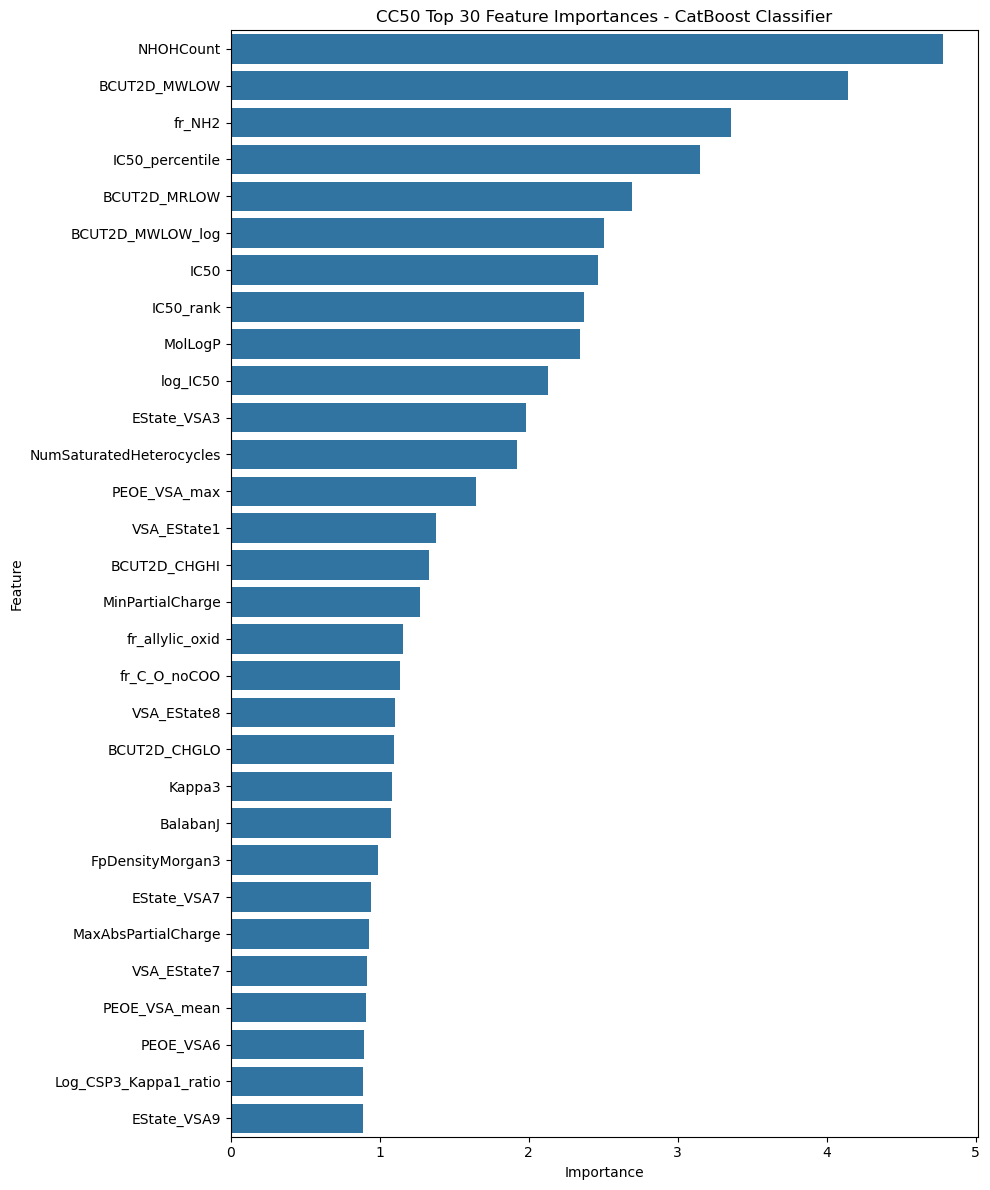


--- До калибровки ---
              precision    recall  f1-score   support

           0       0.77      0.63      0.70       101
           1       0.69      0.81      0.74       100

    accuracy                           0.72       201
   macro avg       0.73      0.72      0.72       201
weighted avg       0.73      0.72      0.72       201

Accuracy: 0.7214
ROC AUC:  0.8281

--- После калибровки Platt Scaling ---
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       101
           1       0.70      0.81      0.75       100

    accuracy                           0.73       201
   macro avg       0.74      0.73      0.73       201
weighted avg       0.74      0.73      0.73       201

Accuracy: 0.7313
ROC AUC:  0.8281


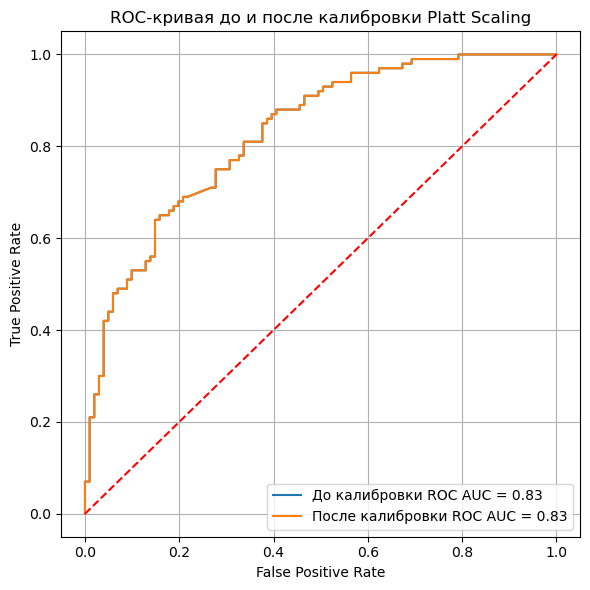

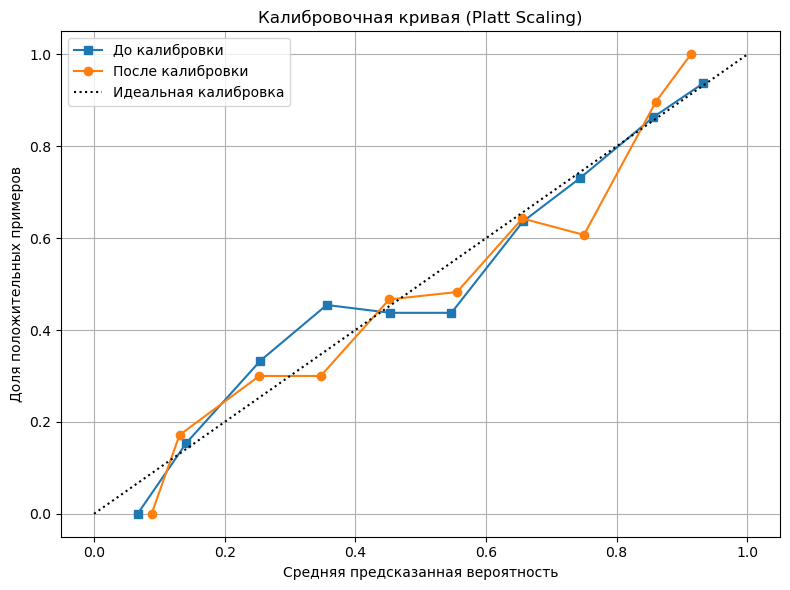


Откалиброванная модель сохранена как 'CC50_classifier_catboost_top25_calibrated_model.pkl'


In [21]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Подготовка данных ---
df = df.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['CC50_above_median'], errors='ignore', inplace=True)

# --- 1.1 Добавление признака log_IC50 из регрессионной модели ---
reg_model = joblib.load('regression_IC50_catboost_final_model_to CC50_class.pkl')

X_features = df.drop(columns=[col for col in df.columns if 'cc50' in col.lower()], errors='ignore')
imputer_reg = SimpleImputer(strategy='most_frequent')
X_imputed_reg = pd.DataFrame(imputer_reg.fit_transform(X_features), columns=X_features.columns)

scaler_reg = RobustScaler()
X_scaled_reg = pd.DataFrame(scaler_reg.fit_transform(X_imputed_reg), columns=X_features.columns)

log_ic50_pred = reg_model.predict(X_scaled_reg)
df['log_IC50'] = log_ic50_pred
df['IC50'] = 10**df['log_IC50']
df['IC50_rank'] = df['IC50'].rank(method='average')
df['IC50_percentile'] = df['IC50'].rank(pct=True)

# --- 1.2 Обработка CC50 ---
cc50_columns = [col for col in df.columns if 'cc50' in col.lower()]
if not cc50_columns:
    raise ValueError("Нет колонки, содержащей 'CC50' в названии.")
cc50_col = cc50_columns[0]

CC50 = df[cc50_col]
X = df.drop(columns=[cc50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Целевая переменная ---
median_cc50_global = CC50.median()
y_binary = (CC50 > median_cc50_global).astype(int)

# --- 4. Важность признаков ---
cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled, y_binary)

feature_importances = cat_model_full.get_feature_importance(Pool(X_scaled, label=y_binary))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("CC50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("CC50_classification_feature_importance.png")
plt.show()

# --- 5. Топ-25 признаков ---
top25_features = feat_imp_df['Feature'].head(26).tolist()
X_scaled_top25 = X_scaled[top25_features]

# --- 6. Разделение на train/test ---
X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X_scaled_top25, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# --- 7. Дальнейшее разбиение train на train_model и calibration set ---
X_train_model, X_calib, y_train_model, y_calib = train_test_split(
    X_train_25, y_train_25, test_size=0.2, random_state=42, stratify=y_train_25
)

# --- 8. Обучение модели на train_model ---
model_top25 = CatBoostClassifier(**catboost_params)
model_top25.fit(X_train_model, y_train_model)

# --- 9. Оценка до калибровки ---
y_pred_test = model_top25.predict(X_test_25)
y_proba_test = model_top25.predict_proba(X_test_25)[:, 1]

print("\n--- До калибровки ---")
print(classification_report(y_test_25, y_pred_test))
print(f"Accuracy: {accuracy_score(y_test_25, y_pred_test):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test_25, y_proba_test):.4f}")

# --- 10. Калибровка с Platt Scaling ---
calibrated_model = CalibratedClassifierCV(model_top25, method='sigmoid', cv='prefit')
calibrated_model.fit(X_calib, y_calib)

# --- 11. Оценка после калибровки ---
y_pred_test_cal = calibrated_model.predict(X_test_25)
y_proba_test_cal = calibrated_model.predict_proba(X_test_25)[:, 1]

print("\n--- После калибровки Platt Scaling ---")
print(classification_report(y_test_25, y_pred_test_cal))
print(f"Accuracy: {accuracy_score(y_test_25, y_pred_test_cal):.4f}")
print(f"ROC AUC:  {roc_auc_score(y_test_25, y_proba_test_cal):.4f}")

# --- 12. ROC-кривая ---
fpr, tpr, _ = roc_curve(y_test_25, y_proba_test)
fpr_cal, tpr_cal, _ = roc_curve(y_test_25, y_proba_test_cal)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"До калибровки ROC AUC = {roc_auc_score(y_test_25, y_proba_test):.2f}")
plt.plot(fpr_cal, tpr_cal, label=f"После калибровки ROC AUC = {roc_auc_score(y_test_25, y_proba_test_cal):.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая до и после калибровки Platt Scaling")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_top25_roc_curve_calibrated.png")
plt.show()

# --- 13. Калибровочная кривая (Calibration curve) ---
fraction_pos_raw, mean_pred_raw = calibration_curve(y_test_25, y_proba_test, n_bins=10)
fraction_pos_cal, mean_pred_cal = calibration_curve(y_test_25, y_proba_test_cal, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_pred_raw, fraction_pos_raw, "s-", label="До калибровки")
plt.plot(mean_pred_cal, fraction_pos_cal, "o-", label="После калибровки")
plt.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")
plt.xlabel("Средняя предсказанная вероятность")
plt.ylabel("Доля положительных примеров")
plt.title("Калибровочная кривая (Platt Scaling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("CC50_top25_calibration_curve.png")
plt.show()

# --- 14. Сохранение откалиброванной модели ---
joblib.dump(calibrated_model, 'CC50_classifier_catboost_top25_calibrated_model.pkl')
print("\nОткалиброванная модель сохранена как 'CC50_classifier_catboost_top25_calibrated_model.pkl'")


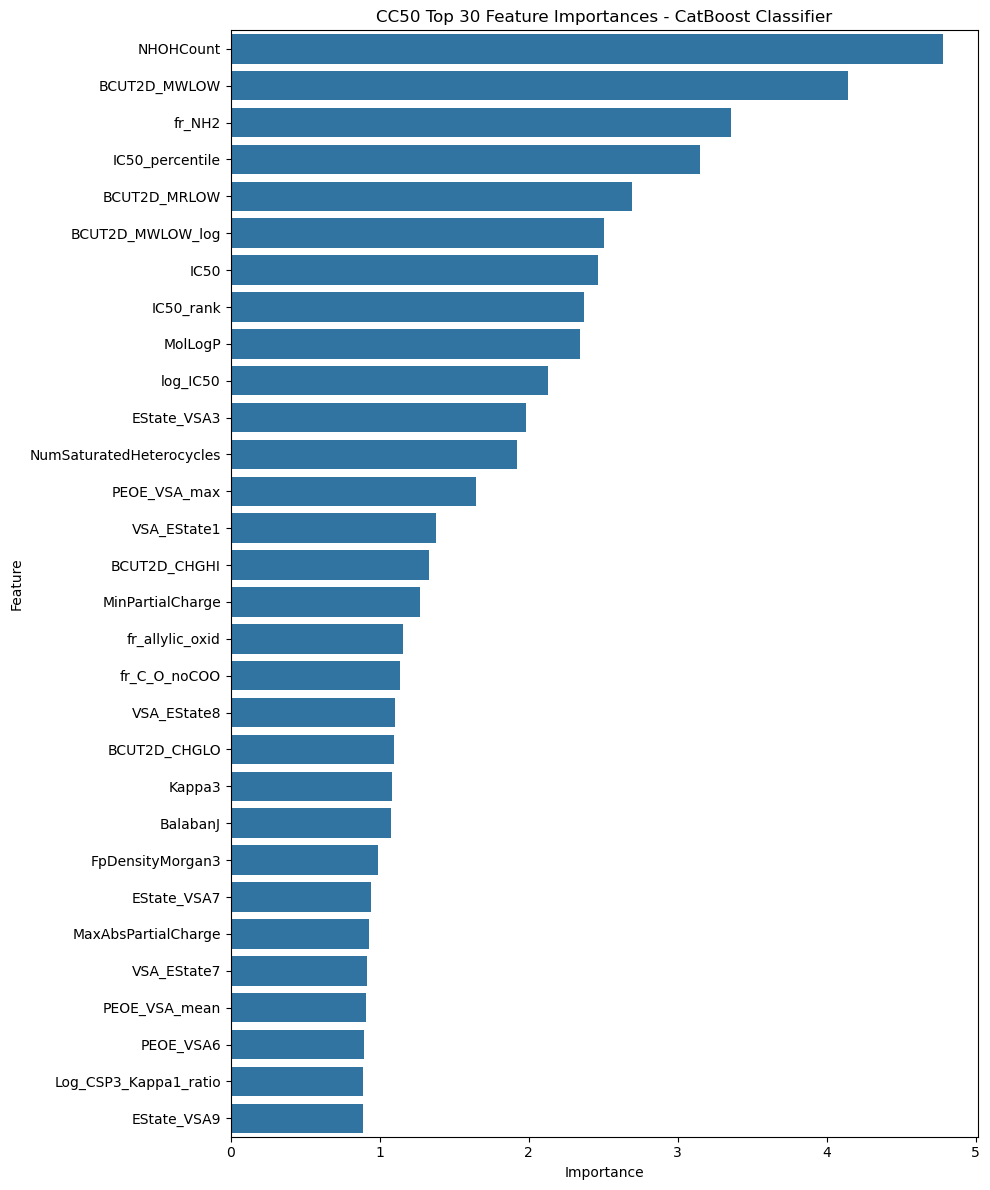

head: 16
Test Accuracy: 0.7363
Test ROC AUC:  0.8294

head: 17
Test Accuracy: 0.7313
Test ROC AUC:  0.8255

head: 18
Test Accuracy: 0.7114
Test ROC AUC:  0.8272

head: 19
Test Accuracy: 0.7164
Test ROC AUC:  0.8247

head: 20
Test Accuracy: 0.7214
Test ROC AUC:  0.8388

head: 21
Test Accuracy: 0.7413
Test ROC AUC:  0.8485

head: 22
Test Accuracy: 0.7065
Test ROC AUC:  0.8349

head: 23
Test Accuracy: 0.7463
Test ROC AUC:  0.8576

head: 24
Test Accuracy: 0.7313
Test ROC AUC:  0.8428

head: 25
Test Accuracy: 0.7363
Test ROC AUC:  0.8498

head: 26
Test Accuracy: 0.7413
Test ROC AUC:  0.8516

head: 27
Test Accuracy: 0.7313
Test ROC AUC:  0.8450

head: 28
Test Accuracy: 0.7065
Test ROC AUC:  0.8439

head: 29
Test Accuracy: 0.7463
Test ROC AUC:  0.8400

head: 30
Test Accuracy: 0.7363
Test ROC AUC:  0.8504

head: 31
Test Accuracy: 0.7264
Test ROC AUC:  0.8484

head: 32
Test Accuracy: 0.7164
Test ROC AUC:  0.8453

head: 33
Test Accuracy: 0.7363
Test ROC AUC:  0.8452

head: 34
Test Accuracy: 0.73

In [39]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Подготовка данных ---
df = df.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['CC50_above_median'], errors='ignore', inplace=True)

# --- 1.1 Добавление признака log_IC50 из регрессионной модели ---
reg_model = joblib.load('regression_IC50_catboost_final_model_to CC50_class.pkl')

X_features = df.drop(columns=[col for col in df.columns if 'cc50' in col.lower()], errors='ignore')
imputer_reg = SimpleImputer(strategy='most_frequent')
X_imputed_reg = pd.DataFrame(imputer_reg.fit_transform(X_features), columns=X_features.columns)

scaler_reg = RobustScaler()
X_scaled_reg = pd.DataFrame(scaler_reg.fit_transform(X_imputed_reg), columns=X_features.columns)

log_ic50_pred = reg_model.predict(X_scaled_reg)
df['log_IC50'] = log_ic50_pred
df['IC50'] = 10**df['log_IC50']
df['IC50_rank'] = df['IC50'].rank(method='average')
df['IC50_percentile'] = df['IC50'].rank(pct=True)

# --- 1.2 Обработка CC50 ---
cc50_columns = [col for col in df.columns if 'cc50' in col.lower()]
if not cc50_columns:
    raise ValueError("Нет колонки, содержащей 'CC50' в названии.")
cc50_col = cc50_columns[0]

CC50 = df[cc50_col]
X = df.drop(columns=[cc50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Целевая переменная ---
median_cc50_global = CC50.median()
y_binary = (CC50 > median_cc50_global).astype(int)

# --- 4. Важность признаков ---
cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled, y_binary)

feature_importances = cat_model_full.get_feature_importance(Pool(X_scaled, label=y_binary))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("CC50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("CC50_classification_feature_importance.png")
plt.show()

# --- 5–7. Прогон topN_features от 16 до 66 ---
for N in range(16, 67):
    topN_features = feat_imp_df['Feature'].head(N).tolist()
    X_scaled_topN = X_scaled[topN_features]

    X_train_N, X_test_N, y_train_N, y_test_N = train_test_split(
        X_scaled_topN, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    model_N = CatBoostClassifier(**catboost_params)
    model_N.fit(X_train_N, y_train_N)

    y_pred_N = model_N.predict(X_test_N)
    y_proba_N = model_N.predict_proba(X_test_N)[:, 1]

    acc_N = accuracy_score(y_test_N, y_pred_N)
    roc_auc_N = roc_auc_score(y_test_N, y_proba_N)

    print(f"head: {N}")
    print(f"Test Accuracy: {acc_N:.4f}")
    print(f"Test ROC AUC:  {roc_auc_N:.4f}\n")
